# Libraries

In [108]:
# Libraries for managing dataframes
import pandas as pd
import numpy as np
from numpy import array
from datetime import datetime, timedelta

# Libraries for computing functions and indices
import math
import ta
import tsfresh
import scipy.stats as stats
import hurst

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Standardization and choice of parameters
from sklearn.preprocessing import StandardScaler
from pmdarima.arima import auto_arima

# Libraries for models
from statsmodels.tsa.arima.model import ARIMA
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Libraries for evaluation matrices
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, auc

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Preprocessing 

### Import the datasets

In [109]:
# Read my stocks and indexes from csv files
amazon_df = pd.read_csv('./Weekly series/Amazon_weekly.csv')
cac_df = pd.read_csv('./Weekly series/Cac_weekly.csv')
ibm_df = pd.read_csv('./Weekly series/IBM_weekly.csv')
microsoft_df = pd.read_csv('./Weekly series/Microsoft_weekly.csv')
sp500_df = pd.read_csv('./Weekly series/Sp500_weekly.csv')
nasdaq_df = pd.read_csv('./Weekly series/Nasdaq_weekly.csv')

In [110]:
sp500_df.head(2)

,Date,Open,High,Low,Close,Volume
0,1994-03-06,466.07,469.16,457.49,464.74,1537910000
1,1994-03-13,464.74,468.07,462.46,466.44,1566770000


Dfs share all the same structure
### Check encoding

In [111]:
nasdaq_encoding = nasdaq_df.dtypes
sp500_encoding = sp500_df.dtypes
amazon_encoding = amazon_df.dtypes
cac_encoding = cac_df.dtypes
ibm_encoding = ibm_df.dtypes
microsoft_encoding = microsoft_df.dtypes

encodings_df = pd.concat([amazon_encoding, cac_encoding, ibm_encoding, microsoft_encoding, sp500_encoding, nasdaq_encoding], axis=1)
encodings_df.columns = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'SP500', 'Nasdaq']
print("Features encoding in our stocks and indexes:\n")
print(encodings_df)

Features encoding in our stocks and indexes:

         Amazon      CAC      IBM Microsoft    SP500   Nasdaq
Date     object   object   object    object   object   object
Open    float64  float64  float64   float64  float64  float64
High    float64  float64  float64   float64  float64  float64
Low     float64  float64  float64   float64  float64  float64
Close   float64  float64  float64   float64  float64  float64
Volume    int64  float64    int64     int64    int64    int64


Encode Date in the right way

In [112]:
dfs = [amazon_df, cac_df, ibm_df, microsoft_df, sp500_df, nasdaq_df]

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'])

In [113]:
sp500_df.head(2)

,Date,Open,High,Low,Close,Volume
0,1994-03-06,466.07,469.16,457.49,464.74,1537910000
1,1994-03-13,464.74,468.07,462.46,466.44,1566770000


### Check missing values

In [114]:
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'SP500', 'Nasdaq']

# Check the number of missing values in each dataset
missing_values_df = pd.concat([amazon_df.isnull().sum(), cac_df.isnull().sum(), ibm_df.isnull().sum(), microsoft_df.isnull().sum(), sp500_df.isnull().sum(), nasdaq_df.isnull().sum()], axis=1)
missing_values_df.columns = names
print("Concatenated missing values: \n")
print(missing_values_df)

Concatenated missing values: 

        Amazon  CAC  IBM  Microsoft  SP500  Nasdaq
Date         0    0    0          0      0       0
Open         0    2    0          0      2       2
High         0    2    0          0      2       2
Low          0    2    0          0      2       2
Close        0    2    0          0      2       2
Volume       0    0    0          0      0       0


- Stocks does not have missing values 
- indexes share the same number of missing values on the same columns
### Spot records with missing values

In [115]:
i = 0
names_indexes = ['CAC', 'SP500', 'Nasdaq']
indexes = [cac_df, sp500_df, nasdaq_df]

for df in indexes:
    missing_values = df[df.isnull().any(axis=1)]
    print(f"Records with missing values in {names_indexes[i]}:")
    i += 1
    print(missing_values)
    print()

Records with missing values in CAC:
           Date  Open  High  Low  Close  Volume
1523 2023-05-14   NaN   NaN  NaN    NaN     0.0
1524 2023-05-21   NaN   NaN  NaN    NaN     0.0

Records with missing values in SP500:
           Date  Open  High  Low  Close  Volume
1523 2023-05-14   NaN   NaN  NaN    NaN       0
1524 2023-05-21   NaN   NaN  NaN    NaN       0

Records with missing values in Nasdaq:
           Date  Open  High  Low  Close  Volume
1523 2023-05-14   NaN   NaN  NaN    NaN       0
1524 2023-05-21   NaN   NaN  NaN    NaN       0



By zooming out and including the previous and next two rows in the visualisation, we can see that they all have the same behaviour.

In [116]:
for df, name in zip(indexes, names_indexes):
    records_range = df[(df['Date'] >= datetime.strptime('2023-04-30', '%Y-%m-%d')) & (df['Date'] <= datetime.strptime('2023-06-04', '%Y-%m-%d'))]
    records_range = records_range.sort_values('Date', ascending=False)
    print(f"Records in {name}_df within the range '2023-04-30' to '2023-06-04':")
    print(records_range,'\n')

Records in CAC_df within the range '2023-04-30' to '2023-06-04':
           Date     Open     High      Low    Close       Volume
1526 2023-06-04  7352.93  7356.57  7083.60  7270.69  446640000.0
1525 2023-05-28  7457.18  7459.37  7197.40  7319.18  260960000.0
1524 2023-05-21      NaN      NaN      NaN      NaN          0.0
1523 2023-05-14      NaN      NaN      NaN      NaN          0.0
1522 2023-05-07  7466.82  7505.92  7374.06  7403.83  144150000.0
1521 2023-04-30  7545.60  7581.26  7403.20  7491.50  394540000.0 

Records in SP500_df within the range '2023-04-30' to '2023-06-04':
           Date       Open       High        Low      Close       Volume
1526 2023-06-04  4226.7100  4290.6699  4166.1499  4282.3701  12275781000
1525 2023-05-28  4176.7998  4212.8701  4103.9800  4205.4502  10130943000
1524 2023-05-21        NaN        NaN        NaN        NaN            0
1523 2023-05-14        NaN        NaN        NaN        NaN            0
1522 2023-05-07  4166.7900  4186.9199  4089.72

### Imputation

Open price is usually equal or at least very similar to the Close price of the previous week. 
- Thus we can impute **close price of 2023-05-21** with open price of 2023-05-28 and **open price of 2023-05-14** with close price of 2023-05-07 with high confidence.
- **2023-05-14 Close and 2023-05-21 Open** will be reasonably imputated as the mean between 2023-05-14 Open and 2023-05-21 Close.

In [117]:
for df in indexes:
    df.loc[df['Date'] == '2023-05-21', 'Close'] = df.loc[df['Date'] == '2023-05-28', 'Open'].values[0]
    df.loc[df['Date'] == '2023-05-14', 'Open'] = df.loc[df['Date'] == '2023-05-07', 'Close'].values[0]
    df.loc[df['Date'] == '2023-05-14', 'Close'] = (df.loc[df['Date'] == '2023-05-14', 'Open'].values[0] + df.loc[df['Date'] == '2023-05-21', 'Close'].values[0]) / 2
    df.loc[df['Date'] == '2023-05-21', 'Open'] = (df.loc[df['Date'] == '2023-05-14', 'Open'].values[0] + df.loc[df['Date'] == '2023-05-21', 'Close'].values[0]) / 2

In [118]:
for df, name in zip(indexes, names_indexes):
    records_range = df[(df['Date'] >= datetime.strptime('2023-04-30', '%Y-%m-%d')) & (df['Date'] <= datetime.strptime('2023-06-04', '%Y-%m-%d'))]
    records_range = records_range.sort_values('Date', ascending=False)
    print(f"Records in {name}_df within the range '2023-04-30' to '2023-06-04':")
    print(records_range,'\n')

Records in CAC_df within the range '2023-04-30' to '2023-06-04':
           Date      Open     High      Low     Close       Volume
1526 2023-06-04  7352.930  7356.57  7083.60  7270.690  446640000.0
1525 2023-05-28  7457.180  7459.37  7197.40  7319.180  260960000.0
1524 2023-05-21  7430.505      NaN      NaN  7457.180          0.0
1523 2023-05-14  7403.830      NaN      NaN  7430.505          0.0
1522 2023-05-07  7466.820  7505.92  7374.06  7403.830  144150000.0
1521 2023-04-30  7545.600  7581.26  7403.20  7491.500  394540000.0 

Records in SP500_df within the range '2023-04-30' to '2023-06-04':
           Date       Open       High        Low      Close       Volume
1526 2023-06-04  4226.7100  4290.6699  4166.1499  4282.3701  12275781000
1525 2023-05-28  4176.7998  4212.8701  4103.9800  4205.4502  10130943000
1524 2023-05-21  4154.4348        NaN        NaN  4176.7998            0
1523 2023-05-14  4132.0698        NaN        NaN  4154.4348            0
1522 2023-05-07  4166.7900  4186

A reasonable way to impute Highest & Lowest price of the week values is:
- Put the **greater among the Open & Close price as High**
- Put the **lower among the Open & Close price as Low**

In [119]:
# Create a list of dates to check
dates = ['2023-05-14', '2023-05-21']

# Check the values of the 'Open' and 'Close' columns for the dates in the list
for df in indexes:
    for date in dates:
        df.loc[df['Date'] == date, ['High', 'Low']] = [max(df.loc[df['Date'] == date, ['Open', 'Close']].values[0]), 
                                                                   min(df.loc[df['Date'] == date, ['Open', 'Close']].values[0])]

How to impute volume?

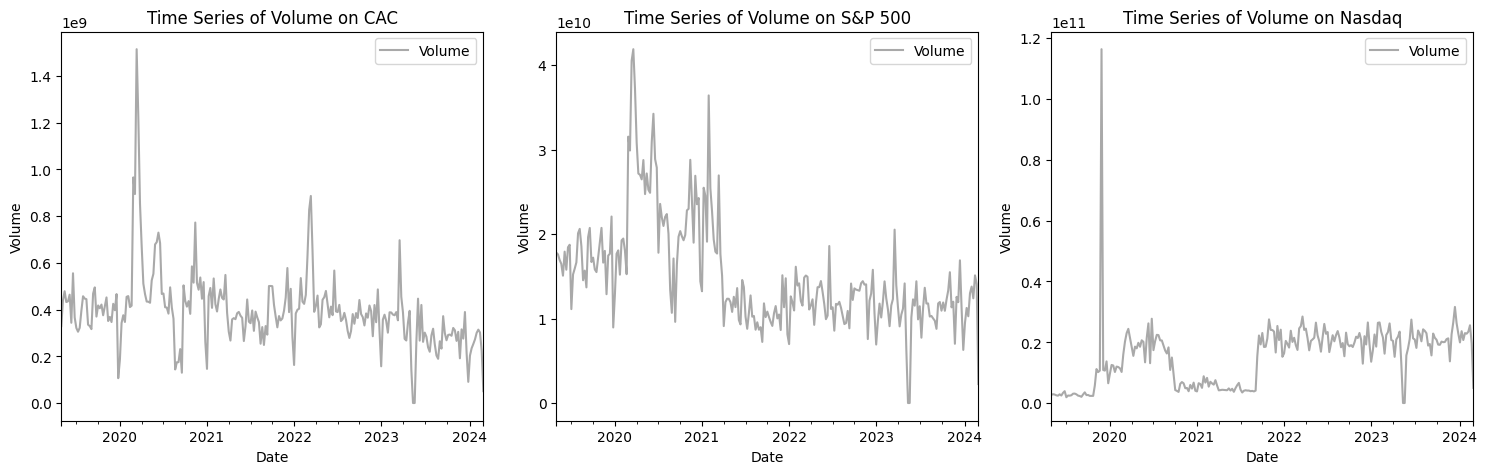

In [120]:
cac_last_5_years = cac_df[cac_df['Date'] >= datetime.now() - timedelta(days=365*5)]
sp500_last_5_years = sp500_df[sp500_df['Date'] >= datetime.now() - timedelta(days=365*5)]
nasdaq_last_5_years = nasdaq_df[nasdaq_df['Date'] >= datetime.now() - timedelta(days=365*5)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the Date and Volume columns for cac_df
cac_last_5_years.plot(x='Date', y='Volume', color = 'darkgrey', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Volume')
axs[0].set_title('Time Series of Volume on CAC')

# Plot the Date and Volume columns for sp500_df
sp500_last_5_years.plot(x='Date', y='Volume', color = 'darkgrey', ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volume')
axs[1].set_title('Time Series of Volume on S&P 500')

# Plot the Date and Volume columns for nasdaq_df
nasdaq_last_5_years.plot(x='Date', y='Volume', color = 'darkgrey', ax=axs[2])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Volume')
axs[2].set_title('Time Series of Volume on Nasdaq')

plt.tight_layout()
plt.show()


Looking at the distribution of volume over the last 5 years a good imputation is the **mean of the volume had during that year**.

In [121]:
# Dates where to impute
dates = ['2023-05-14', '2023-05-21']

# Impute as the mean of the volume in 2023
for df in indexes:
    df.loc[(df['Date'] == dates[0]) | (df['Date'] == dates[1]), ['Volume']] = df.loc[df['Date'].dt.year == 2023, 'Volume'].mean()


In [122]:
for df, name in zip(indexes, names_indexes):
    records_range = df[(df['Date'] >= datetime.strptime('2023-04-30', '%Y-%m-%d')) & (df['Date'] <= datetime.strptime('2023-06-04', '%Y-%m-%d'))]
    records_range = records_range.sort_values('Date', ascending=False)
    print(f"Records in {name} within the range '2023-04-30' to '2023-06-04':")
    print(records_range,'\n')

Records in CAC within the range '2023-04-30' to '2023-06-04':
           Date      Open      High       Low     Close        Volume
1526 2023-06-04  7352.930  7356.570  7083.600  7270.690  4.466400e+08
1525 2023-05-28  7457.180  7459.370  7197.400  7319.180  2.609600e+08
1524 2023-05-21  7430.505  7457.180  7430.505  7457.180  2.966588e+08
1523 2023-05-14  7403.830  7430.505  7403.830  7430.505  2.966588e+08
1522 2023-05-07  7466.820  7505.920  7374.060  7403.830  1.441500e+08
1521 2023-04-30  7545.600  7581.260  7403.200  7491.500  3.945400e+08 

Records in SP500 within the range '2023-04-30' to '2023-06-04':
           Date       Open       High        Low      Close        Volume
1526 2023-06-04  4226.7100  4290.6699  4166.1499  4282.3701  1.227578e+10
1525 2023-05-28  4176.7998  4212.8701  4103.9800  4205.4502  1.013094e+10
1524 2023-05-21  4154.4348  4176.7998  4154.4348  4176.7998  1.096365e+10
1523 2023-05-14  4132.0698  4154.4348  4132.0698  4154.4348  1.096365e+10
1522 2023-05

# Handle stock splits

### Amazon

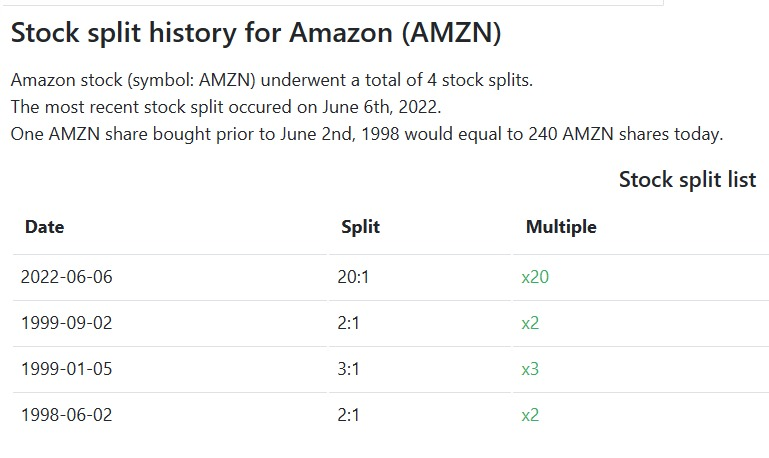

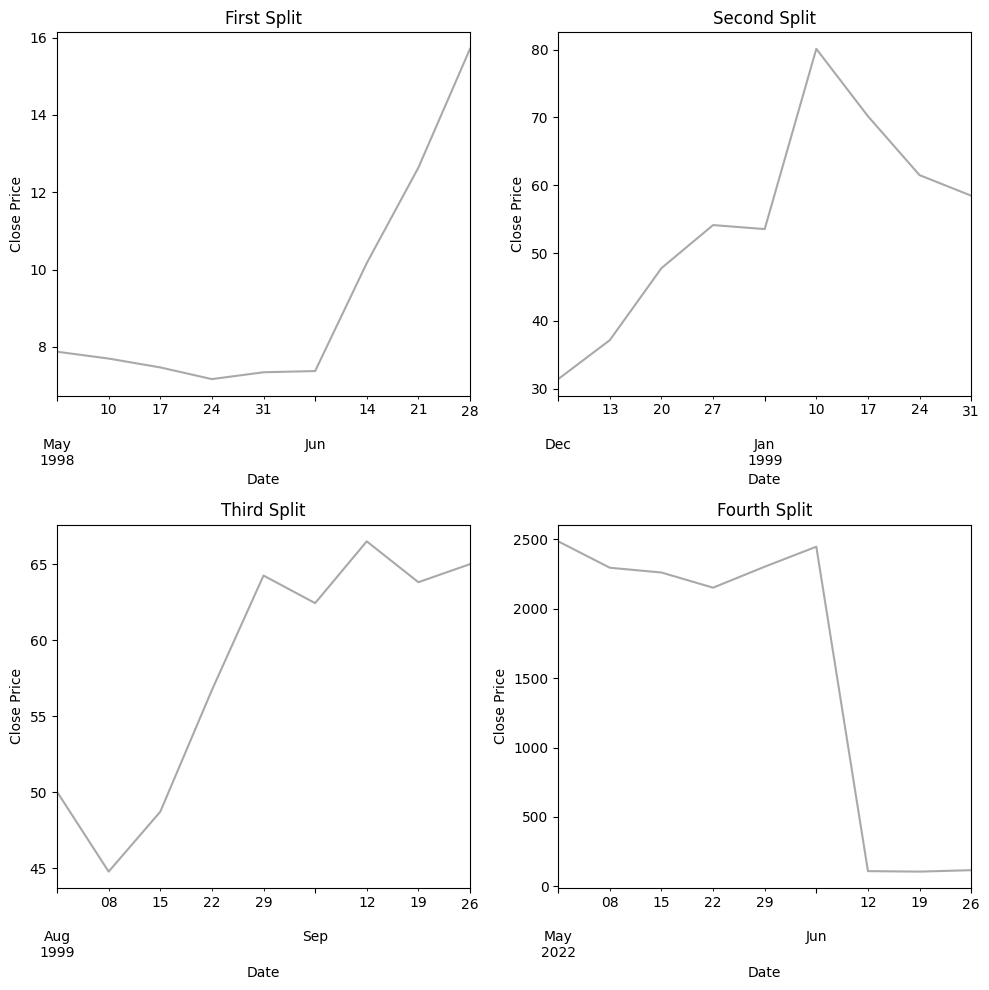

In [123]:
# Select the windows when the splits happened
first_split = amazon_df.loc[(amazon_df['Date'] >= '1998-05-01') & (amazon_df['Date'] <= '1998-07-01')]
second_split = amazon_df.loc[(amazon_df['Date'] >= '1998-12-01') & (amazon_df['Date'] <= '1999-02-01')]
third_split = amazon_df.loc[(amazon_df['Date'] >= '1999-08-01') & (amazon_df['Date'] <= '1999-10-01')]
fourth_split = amazon_df.loc[(amazon_df['Date'] >= '2022-05-01') & (amazon_df['Date'] <= '2022-07-01')]

# Plotting the data with improvements
fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

# First split
first_split.plot(x='Date', y='Close', ax=axs[0, 0], title='First Split', legend=False, color='darkgrey')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Close Price')

# Second split
second_split.plot(x='Date', y='Close', ax=axs[0, 1], title='Second Split', legend=False, color='darkgrey')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Close Price')

# Third split
third_split.plot(x='Date', y='Close', ax=axs[1, 0], title='Third Split', legend=False, color='darkgrey')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Close Price')

# Fourth
fourth_split.plot(x='Date', y='Close', ax=axs[1, 1], title='Fourth Split', legend=False, color='darkgrey')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Close Price')

plt.show()


The only split reflected on the data is the fourth.

In [124]:
# Multiply close prices of amazon after 2022-06-05 by 20
amazon_df.loc[amazon_df['Date'] > '2022-06-05', 'Close'] *= 20

Let's visualize the updated data

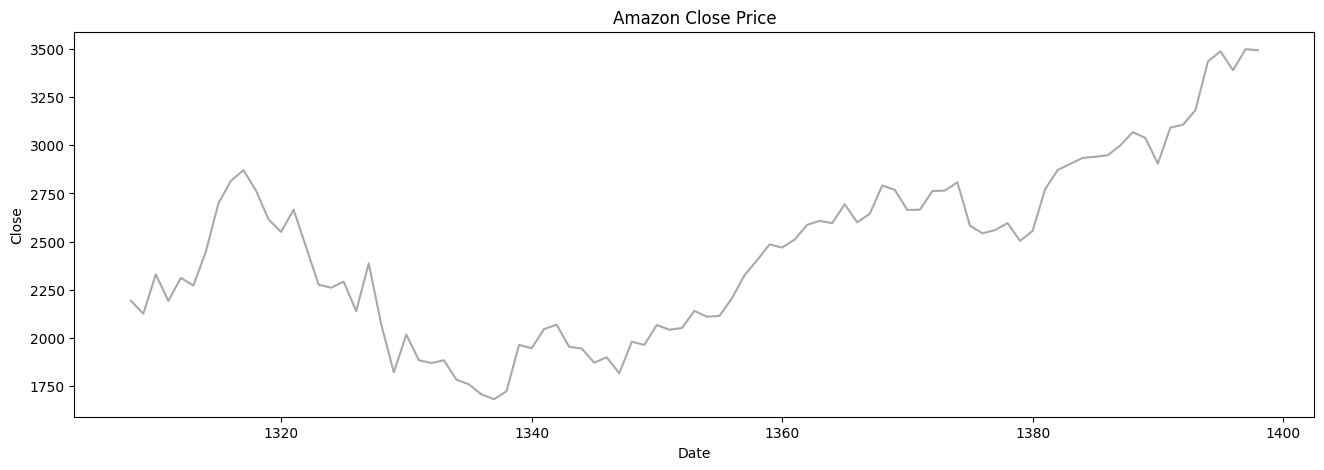

In [125]:
# Plot updated data
plt.figure(figsize=(16,5))
amazon_df.loc[amazon_df['Date'] > '2022-06-05', 'Close'].plot(x='Date', y='Close', color = 'darkgrey')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Amazon Close Price')
plt.show()


#### Microsoft

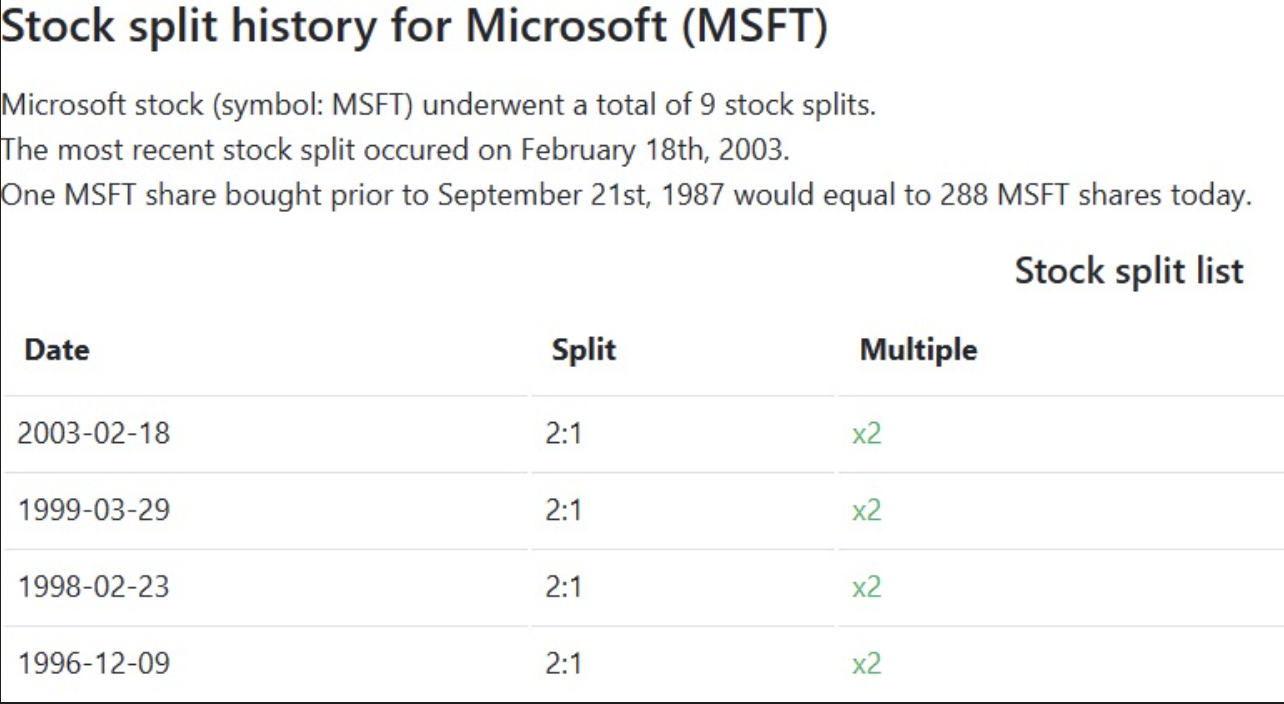

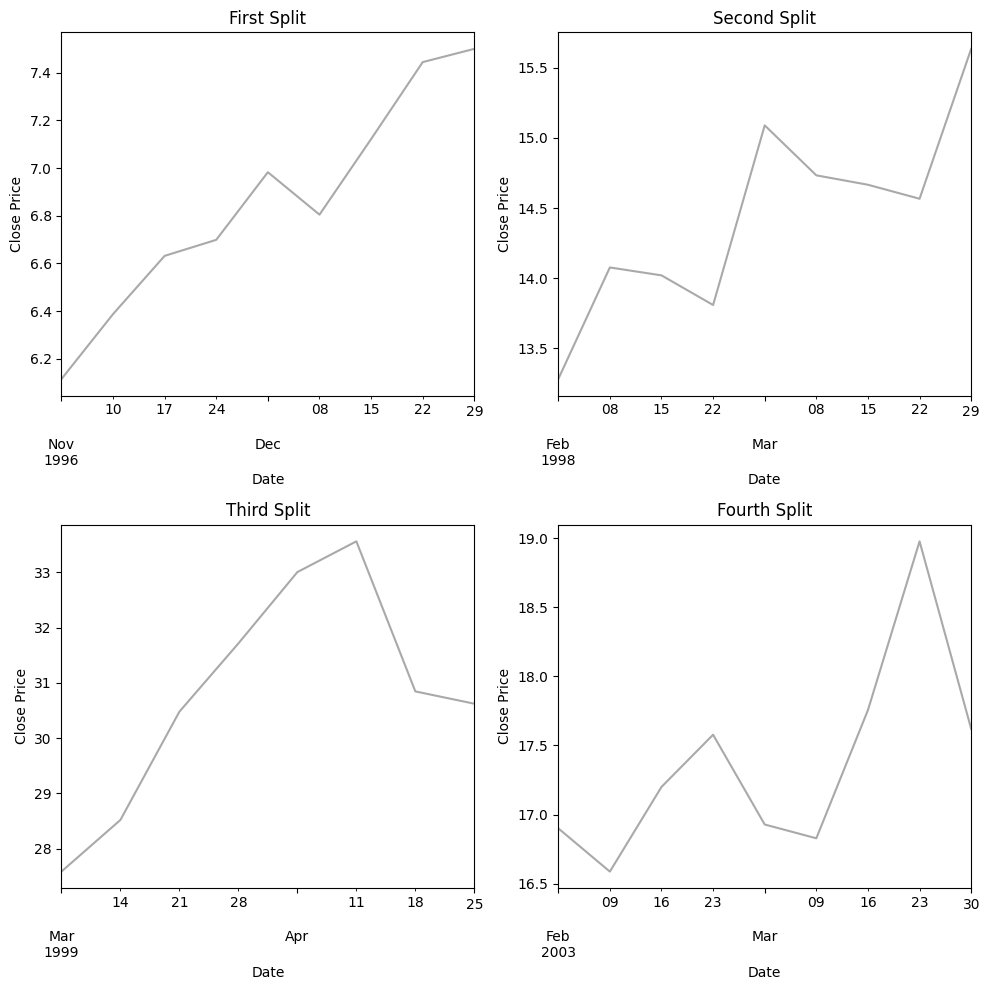

In [126]:
# Select the windows when the splits happened
first_split = microsoft_df.loc[(microsoft_df['Date'] >= '1996-11-01') & (microsoft_df['Date'] <= '1997-01-01')]
second_split = microsoft_df.loc[(microsoft_df['Date'] >= '1998-02-01') & (microsoft_df['Date'] <= '1998-04-01')]
third_split = microsoft_df.loc[(microsoft_df['Date'] >= '1999-03-01') & (microsoft_df['Date'] <= '1999-05-01')]
fourth_split = microsoft_df.loc[(microsoft_df['Date'] >= '2003-02-01') & (microsoft_df['Date'] <= '2003-04-01')]

# Plotting the data with improvements
fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

# First split
first_split.plot(x='Date', y='Close', ax=axs[0, 0], title='First Split', legend=False, color='darkgrey')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Close Price')

# Second split
second_split.plot(x='Date', y='Close', ax=axs[0, 1], title='Second Split', legend=False, color='darkgrey')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Close Price')

# Third split
third_split.plot(x='Date', y='Close', ax=axs[1, 0], title='Third Split', legend=False, color='darkgrey')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Close Price')

# Fourth split
fourth_split.plot(x='Date', y='Close', ax=axs[1, 1], title='Fourth Split', legend=False, color='darkgrey')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Close Price')

plt.show()

No split to deal with

### IBM

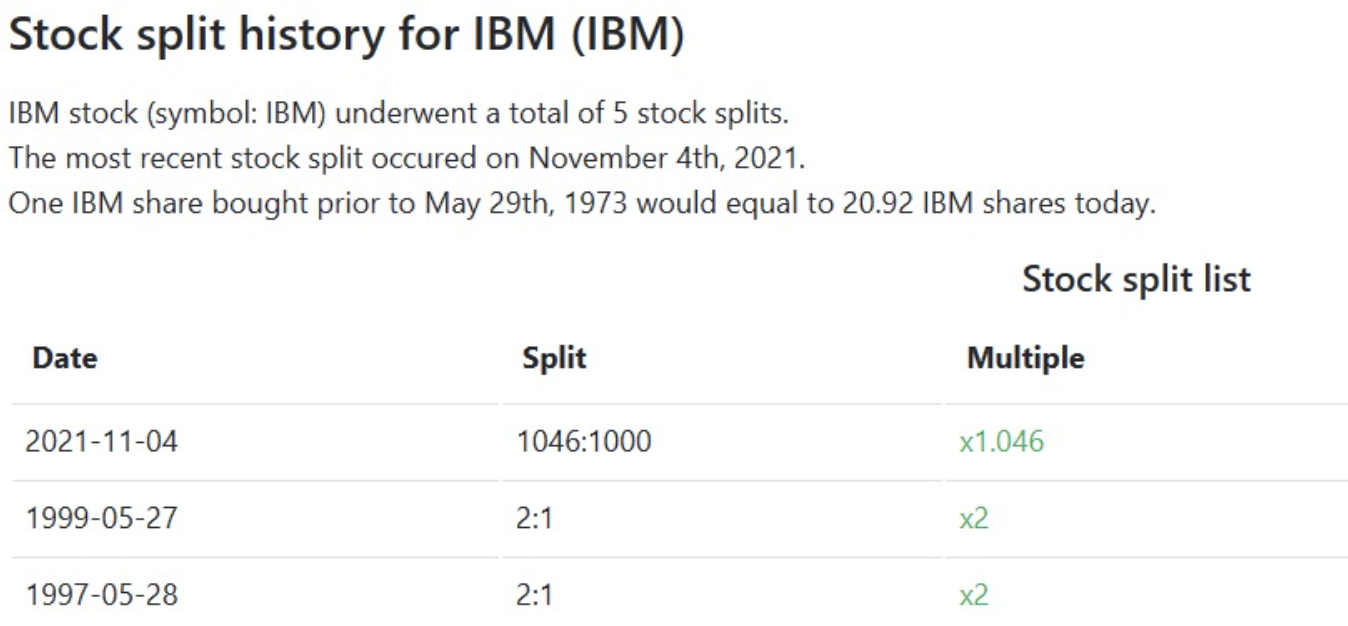

Text(0.5, 1.0, 'IBM Close Price in the Third Split')

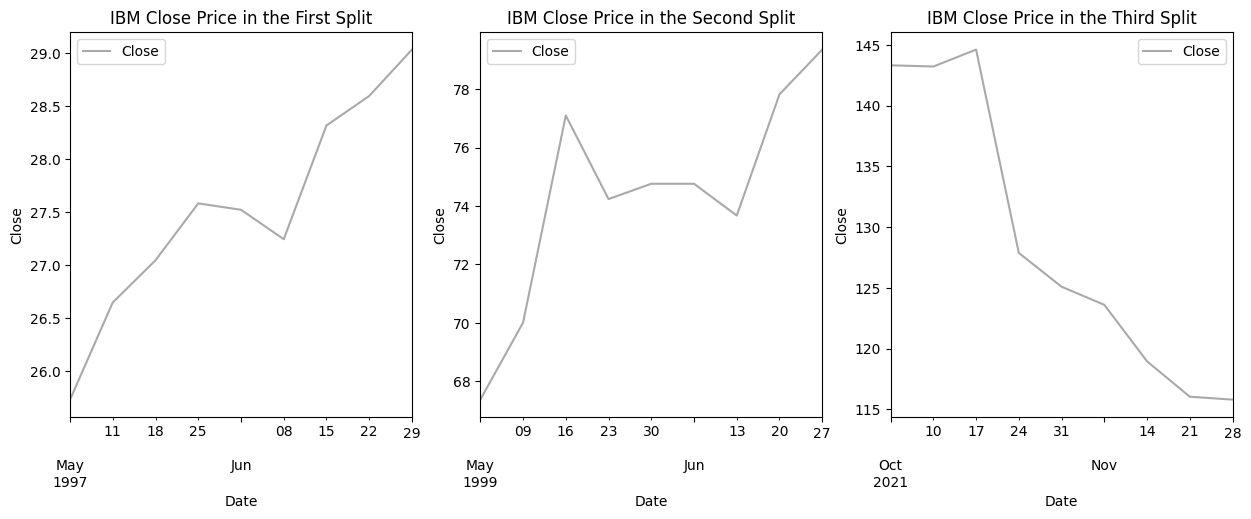

In [127]:
# Select the windows when the splits happened
first_split = ibm_df.loc[(ibm_df['Date'] >= '1997-05-01') & (ibm_df['Date'] <= '1997-07-01')]
second_split = ibm_df.loc[(ibm_df['Date'] >= '1999-05-01') & (ibm_df['Date'] <= '1999-07-01')]
third_split = ibm_df.loc[(ibm_df['Date'] >= '2021-10-01') & (ibm_df['Date'] <= '2021-12-01')]

# plot the 3 plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First split 
first_split.plot(x='Date', y='Close', ax=axs[0], color = 'darkgrey')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close')
axs[0].set_title('IBM Close Price in the First Split')

# Second split
second_split.plot(x='Date', y='Close', ax=axs[1], color = 'darkgrey')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Close')
axs[1].set_title('IBM Close Price in the Second Split')

# Third split
third_split.plot(x='Date', y='Close', ax=axs[2], color = 'darkgrey')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Close')
axs[2].set_title('IBM Close Price in the Third Split')

No split to deal with

# Market direction
Compute a column where you compute if the price went up or down w.r.t. the previous week

We used a moderate approach for trade signals, and fit percentage change treshold to go long or short in such a way that we exit the market 30% of the times(more or less).
In this way when the pecentage change is not much w.r.t. the previous week we do not have signal to trade.
This signal will be the output value we will try to predict with our models

In [128]:
def compute_dynamic_threshold(df, alpha=0.3):
    # Calculate daily percentage changes
    percentage_changes = df['Close'].pct_change()
    positive_percentage_changes = percentage_changes[percentage_changes > 0]
    negative_percentage_changes = percentage_changes[percentage_changes < 0]

    # Finding the correct percentile values to stay out of the market 'alpha' percent of the time for both positive and negative percentage changes
    negative_bound = np.percentile(negative_percentage_changes.dropna(), 100 * (1 - alpha)) 
    positive_bound = np.percentile(positive_percentage_changes.dropna(), 100 * alpha)  
    print(negative_bound, positive_bound)
    return negative_bound, positive_bound

def compute_signal(df, alpha=0.3):
    negative_threshold, positive_threshold = compute_dynamic_threshold(df, alpha)

    trading_strategy = [0]  # the first value is 0 because there is no previous day to compare
    previous_close = df['Close'].iloc[0]  # start with the first 'Close' value

    for current_close in df['Close'].iloc[1:]:
        if current_close > (previous_close + previous_close*positive_threshold):
            trading_strategy.append(1)
        elif current_close < (previous_close + previous_close*negative_threshold):
            trading_strategy.append(-1)
        else:
            trading_strategy.append(0)
        previous_close = current_close  # update previous close for next iteration

    return trading_strategy

# Compute a column where you compute if the price went up or down w.r.t. the previous week
def market_direction(df):
    market_direction = ['up']  # the first value is up because there is no previous day to compare, however it will be removed later
    previous_close = df['Close'].iloc[0]  # start with the first 'Close' value

    for current_close in df['Close'].iloc[1:]:
        if current_close > previous_close:
            market_direction.append('up')
        else:
            market_direction.append('down')
        previous_close = current_close  # update previous close for next iteration
    return market_direction

# Applying the functions to our datasets

cac_df['Trading Signal'] = compute_signal(cac_df)
sp500_df['Trading Signal'] = compute_signal(sp500_df)
nasdaq_df['Trading Signal'] = compute_signal(nasdaq_df)
amazon_df['Trading Signal'] = compute_signal(amazon_df)
ibm_df['Trading Signal'] = compute_signal(ibm_df)
microsoft_df['Trading Signal'] = compute_signal(microsoft_df)

cac_df['Market Direction'] = market_direction(cac_df)
sp500_df['Market Direction'] = market_direction(sp500_df)
nasdaq_df['Market Direction'] = market_direction(nasdaq_df)
amazon_df['Market Direction'] = market_direction(amazon_df)
ibm_df['Market Direction'] = market_direction(ibm_df)
microsoft_df['Market Direction'] = market_direction(microsoft_df)

-0.009154749641755623 0.009519351711978952
-0.006881593413823284 0.007681616477211527
-0.007750670416639464 0.010555625993174585
-0.016981024066650186 0.018299469307590938
-0.010008711797356575 0.011845803936426712
-0.011039760747532492 0.012171220205350108


In [129]:
# Count occurences of Trading Signal = 0 in all the stocks and indices
cac_count = cac_df[cac_df['Trading Signal'] == 0].shape[0]
sp500_count = sp500_df[sp500_df['Trading Signal'] == 0].shape[0]
nasdaq_count = nasdaq_df[nasdaq_df['Trading Signal'] == 0].shape[0]
amazon_count = amazon_df[amazon_df['Trading Signal'] == 0].shape[0]
ibm_count = ibm_df[ibm_df['Trading Signal'] == 0].shape[0]
microsoft_count = microsoft_df[microsoft_df['Trading Signal'] == 0].shape[0]
print(cac_count, sp500_count, nasdaq_count, amazon_count, ibm_count, microsoft_count)

471 471 472 424 476 480


In [130]:
cac_df.head()

,Date,Open,High,Low,Close,Volume,Trading Signal,Market Direction
0,1994-03-06,2222.96,2241.72,2079.92,2178.69,0.0,0,up
1,1994-03-13,2199.09,2225.48,2164.52,2174.91,0.0,0,down
2,1994-03-20,2196.77,2260.60,2196.77,2221.34,0.0,1,up
3,1994-03-27,2205.56,2225.15,2113.55,2136.62,0.0,-1,down
4,1994-04-03,2136.42,2165.83,2069.37,2081.94,0.0,-1,down


# Compute indicators and functions

In [131]:
def approx_entropy(ts, m=2, r=None):
    if r is None:
        r = 0.2 * np.std(ts)
    n = len(ts)
    def _phi(m):
        x = np.array([ts[i : i + m] for i in range(n - m + 1)])
        C = np.sum([np.sum(np.abs(x[i] - x) <= r, axis=1) / (n - m + 1) for i in range(n - m + 1)]) / (n - m + 1)
        return np.log(C)
    return _phi(m) - _phi(m + 1)

# Compute technical indicators and time series functions for each dataframe using the ta library
for df in dfs:
    # Technical indicators
    df['sma'] = ta.trend.sma_indicator(df['Close'], window=14) #Simple Moving Averages (SMA)
    df['ema'] = ta.trend.ema_indicator(df['Close'], window=14) # Exponential Moving Averages (EMA)
    df['stoch_osc'] = ta.momentum.stoch(df['High'], df['Low'], df['Close']) # Stochastic Oscillator
    df['rsi'] = ta.momentum.rsi(df['Close']) # Relative Strength Index (RSI)
    df['macd'] = ta.trend.macd(df['Close']) # Moving Average Convergence Divergence (MACD)

- SMA and EMA (14 Weeks): Targets medium-term trends, reflecting quarterly performance which is crucial for understanding market dynamics over significant financial periods.
- Stochastic Oscillator (Default: 14): Spot overbought or oversold conditions, important for predicting potential price reversals on a medium-term basis.
- RSI (14 Weeks): Chosen to evaluate medium-term market momentum, useful in identifying overbought or oversold conditions over a quarter.
- MACD (14 weeks): Utilized to detect changes in medium-term trend strength and direction, offering signals for potential trading opportunities.
- Skewness and Kurtosis (Default: 14): Analyzes the return distribution's asymmetry and tail risks within a quarterly frame, providing insights into market volatility and risk.

In [132]:
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'SP500', 'Nasdaq']

# Definition of the Hurst exponent function
def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    return poly[0] * 2.0

# Calculating and printing the Hurst Exponent for each DataFrame
for df, name in zip(dfs, names):
    H = hurst_exponent(df['Close'].values)
    print(f"Hurst exponent of {name} is {H}")

Hurst exponent of Amazon is 0.5171959162752986
Hurst exponent of CAC is 0.5214438968737874
Hurst exponent of IBM is 0.35625936772773636
Hurst exponent of Microsoft is 0.5170397931108978
Hurst exponent of SP500 is 0.4811362627698107
Hurst exponent of Nasdaq is 0.5306638585286435


Hurst Exponent assesses the entire series to gauge long-term dependency or memory, helping to categorize market behavior as trending, random, or mean-reverting. If 𝐻 > 0.5, the series has a persistent behaviour, so it should be more predictable.

Let's look at the dataset now that we add those indicators

In [133]:
sp500_df.head(51)

,Date,Open,High,Low,Close,Volume,Trading Signal,Market Direction,sma,ema,stoch_osc,rsi,macd
0,1994-03-06,466.07,469.16,457.49,464.74,1.537910e+09,0,up,NaN,NaN,NaN,NaN,NaN
1,1994-03-13,464.74,468.07,462.46,466.44,1.566770e+09,0,up,NaN,NaN,NaN,NaN,NaN
2,1994-03-20,466.44,471.09,465.48,471.06,1.637710e+09,1,up,NaN,NaN,NaN,NaN,NaN
3,1994-03-27,471.06,471.06,460.58,460.58,1.364500e+09,-1,down,NaN,NaN,NaN,NaN,NaN
4,1994-04-03,460.58,461.12,436.16,445.77,1.386810e+09,-1,down,NaN,NaN,NaN,NaN,NaN
5,1994-04-10,445.66,451.10,435.86,447.10,1.565750e+09,0,up,NaN,NaN,NaN,NaN,NaN
6,1994-04-17,447.12,450.80,442.62,446.18,1.363880e+09,0,down,NaN,NaN,NaN,NaN,NaN
7,1994-04-24,446.27,449.96,438.83,447.63,1.635770e+09,0,up,NaN,NaN,NaN,NaN,NaN
8,1994-05-01,447.64,452.79,447.58,450.91,1.169610e+09,0,up,NaN,NaN,NaN,NaN,NaN
9,1994-05-08,450.91,453.98,445.64,447.82,1.399940e+09,0,down,NaN,NaN,NaN,NaN,NaN


- Since on the first 25 rows we miss lot of indicator and functions we just **delete these rows**.

In [134]:
# Function to apply changes to the DataFrames
def modify_df(df):
    modified_df = df.iloc[25:]
    return modified_df

# Explicitly modify each DataFrame
amazon_df = modify_df(amazon_df)
cac_df = modify_df(cac_df)
ibm_df = modify_df(ibm_df)
microsoft_df = modify_df(microsoft_df)
sp500_df = modify_df(sp500_df)
nasdaq_df = modify_df(nasdaq_df)

Let's see at the summary of one among our datasets now that are complete.

In [135]:
amazon_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1374,2011-01-05 12:00:00,1997-11-09 00:00:00,2004-06-07 18:00:00,2011-01-05 12:00:00,2017-08-04 06:00:00,2024-03-03 00:00:00,NaN
Open,1374.0,564.201576,5.91,49.1825,129.725,543.7975,3744.0,908.051749
High,1374.0,583.314133,7.66,52.1925,136.55,572.9575,3773.0781,937.032405
Low,1374.0,547.294646,5.51,46.835,123.925,530.642575,3570.4551,882.642719
Close,1374.0,715.014369,4.125,42.5125,174.36,981.8725,3719.3401,1023.87187
Volume,1374.0,47817349.157205,696100.0,17992174.5,28040350.0,40804915.75,654066422.0,72668085.863142
Trading Signal,1374.0,0.048035,-1.0,-1.0,0.0,1.0,1.0,0.832178
sma,1374.0,699.378638,3.521607,42.858036,171.006429,979.796786,3448.1964,1006.042098
ema,1374.0,699.800782,3.726906,42.00385,169.797802,969.393196,3454.416683,1005.436887
stoch_osc,1374.0,443.474474,-253.357363,27.297153,62.011657,87.98037,12020.913569,1695.095233


# Split

We have choose to go fro 90-10 split

In [136]:
# Function to apply changes to the DataFrames
def train_test(df):
    train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]
    return train_data, test_data

# Explicitly modify each DataFrame
train_amazon, test_amazon = train_test(amazon_df)
train_cac, test_cac = train_test(cac_df)
train_ibm, test_ibm = train_test(ibm_df)
train_microsoft, test_microsoft = train_test(microsoft_df)
train_sp500, test_sp500 = train_test(sp500_df)
train_nasdaq, test_nasdaq = train_test(nasdaq_df)

In [137]:
test_cac.head()

,Date,Open,High,Low,Close,Volume,Trading Signal,Market Direction,sma,ema,stoch_osc,rsi,macd
1411,2021-03-21,6054.49,6089.20,5983.61,5997.96,548124704.0,0,down,5681.819286,5690.566328,88.341724,65.953835,210.295352
1412,2021-03-28,5960.85,6002.95,5886.00,5988.81,386380696.0,0,down,5714.745714,5730.332151,87.172574,65.564484,215.576061
1413,2021-04-04,5995.00,6106.12,5985.36,6102.96,305258896.0,1,up,5756.242143,5780.015864,99.565277,68.094949,226.362645
1414,2021-04-11,6155.22,6188.48,6118.91,6169.41,267397804.0,1,up,5800.385000,5831.935083,97.643526,69.500016,237.534895
1415,2021-04-18,6167.32,6299.56,6151.52,6287.07,357992904.0,1,up,5841.827143,5892.619738,98.642893,71.862865,252.967116


# Standardization

In [138]:
def standardize_data(train_data, test_data):
    scaler = StandardScaler()
    
    # Extract the 'Date' column before scaling
    train_dates = train_data['Date']
    test_dates = test_data['Date']
    # Extract the 'Trading Signal' column before scaling
    train_signals = train_data['Trading Signal']
    test_signals = test_data['Trading Signal']
    # Extract the 'Market Direction' column before scaling
    train_market_direction = train_data['Market Direction']
    test_market_direction = test_data['Market Direction']
    
    # Define the columns to be scaled
    scale_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'ema', 'stoch_osc', 'rsi', 'macd']
    
    # Ensure the data to be scaled does not include the 'Date' column
    train_data_to_scale = train_data[scale_columns]
    test_data_to_scale = test_data[scale_columns]
    
    # Fit and transform the data
    scaler.fit(train_data_to_scale)
    train_scaled = scaler.transform(train_data_to_scale)
    test_scaled = scaler.transform(test_data_to_scale)
    
    # Create DataFrames from the scaled data
    train_scaled_df = pd.DataFrame(train_scaled, columns=scale_columns, index=train_data.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=scale_columns, index=test_data.index)
    
    # Directly assign the 'Date' column to the scaled DataFrames
    # This ensures the 'Date' column aligns with the rest of the data
    train_scaled_df['Date'] = train_dates.values
    test_scaled_df['Date'] = test_dates.values
    train_scaled_df['Trading Signal'] = train_signals.values
    test_scaled_df['Trading Signal'] = test_signals.values
    train_scaled_df['Market Direction'] = train_market_direction.values
    test_scaled_df['Market Direction'] = test_market_direction.values
    
    #  Reindex the DataFrame to achieve this
    train_scaled_df = train_scaled_df[['Date'] + [col for col in train_scaled_df.columns if col != 'Date']]
    test_scaled_df = test_scaled_df[['Date'] + [col for col in test_scaled_df.columns if col != 'Date']]
    
    return train_scaled_df, test_scaled_df


# Apply the function to your data
train_amazon_std, test_amazon_std = standardize_data(train_amazon, test_amazon)
train_cac_std, test_cac_std = standardize_data(train_cac, test_cac)
train_ibm_std, test_ibm_std = standardize_data(train_ibm, test_ibm)
train_microsoft_std, test_microsoft_std = standardize_data(train_microsoft, test_microsoft)
train_sp500_std, test_sp500_std = standardize_data(train_sp500, test_sp500)
train_nasdaq_std, test_nasdaq_std = standardize_data(train_nasdaq, test_nasdaq)

In [139]:
test_cac_std.tail()

,Date,Open,High,Low,Close,Volume,sma,ema,stoch_osc,rsi,macd,Trading Signal,Market Direction
1561,2024-02-04,3.054919,3.009670,3.107294,3.008770,-0.512205,2.885255,2.920256,0.853907,0.520465,0.608311,0,down
1562,2024-02-11,3.009876,2.994449,3.096752,3.057330,-0.463989,2.923243,2.946642,1.024572,0.660251,0.672970,0,up
1563,2024-02-18,3.082242,3.094918,3.132180,3.163360,-0.506089,2.969027,2.983859,1.125713,0.949438,0.785367,1,up
1564,2024-02-25,3.142623,3.247634,3.247875,3.337791,-0.780427,3.015420,3.039719,1.231722,1.357585,0.979540,1,up
1565,2024-03-03,3.324726,3.227402,3.421435,3.305400,-1.382770,3.055751,3.083747,1.067502,1.204790,1.097519,0,down


In [140]:
# DFs of date, close and prediction price for each stock for test
amazon_results = test_amazon_std[['Date', 'Close', 'Trading Signal', 'Market Direction']]
cac_results = test_cac_std[['Date', 'Close', 'Trading Signal', 'Market Direction']]
ibm_results = test_ibm_std[['Date', 'Close', 'Trading Signal', 'Market Direction']]
microsoft_results = test_microsoft_std[['Date', 'Close', 'Trading Signal', 'Market Direction']]
sp500_results = test_sp500_std[['Date', 'Close', 'Trading Signal', 'Market Direction']]
nasdaq_results = test_nasdaq_std[['Date', 'Close', 'Trading Signal', 'Market Direction']]

nasdaq_results.head()

,Date,Close,Trading Signal,Market Direction
1411,2021-03-21,3.976757,-1,down
1412,2021-03-28,3.945713,0,down
1413,2021-04-04,4.084213,1,up
1414,2021-04-11,4.254632,1,up
1415,2021-04-18,4.316362,1,up


# Model 1: ARIMA

#### Choose of the right ARIMA parameters (p,d,q)

Choosing the ARIMA (AutoRegressive Integrated Moving Average) parameters for different time series involves identifying the most suitable values for the model's three main parameters: p (autoregressive term), d (differencing order), and q (moving average term). 

Normally we should rely on the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF). Looking at their plots we should set the parameters such that:

- p (AR terms): look at the PACF plot; the point where it cuts off (i.e., the bars become insignificant beyond a certain lag) can suggest the number of AR terms.
- q (MA terms): the ACF plot helps here; similar to PACF, the cutoff point indicates the possible number of MA terms.

Moreover, we should use differencing (d parameter) to make the series stationary. The number of differences needed can often be determined by repeated testing for stationarity (e.g., using the Augmented Dickey-Fuller test) after each differencing.

Anyway, we could use automated tools like the auto.arima() function select the best p, d and q parameters based on the AIC/BIC values.

In [141]:
def fit_arima(train_data):
    model = auto_arima(train_data['Close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    return model.order

amazon_order = fit_arima(train_amazon_std)
cac_order = fit_arima(train_cac_std)
ibm_order = fit_arima(train_ibm_std)
microsoft_order = fit_arima(train_microsoft_std)
sp500_order = fit_arima(train_sp500_std)
nasdaq_order = fit_arima(train_nasdaq_std)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3244.693, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-3543.348, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3246.680, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-3765.364, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-3840.358, Time=0.11 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-3856.189, Time=0.09 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-3908.281, Time=0.16 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-4103.891, Time=1.19 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-4094.304, Time=0.82 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=-4099.366, Time=1.59 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-4125.368, Time=0.57 sec
 ARIMA(4,2,1)(0,0,0)[0]             :

For instance, let's look at the amazon order assigned by the auto_arima() function

In [142]:
amazon_order

(5, 2, 1)

Run of ARIMA model on each dataset 

In [143]:
def run_arima_model(train_data, test_data, arima_order):
    # Extracting the 'Close' column values for training and testing
    training_data = train_data['Close'].values
    test_data = test_data['Close'].values

    # Preparing the training data history for the ARIMA model
    history = [x for x in training_data]
    model_predictions = []
    in_sample_predictions = []
    N_test_observations = len(test_data)

    # Fit the ARIMA model on the entire training dataset
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()

    # In-sample predictions
    in_sample_predictions = model_fit.predict(start=1, end=len(training_data))

    # Iterating over each time point in the test data
    for time_point in range(N_test_observations):
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)  # Update history for the next forecast
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()

    # Calculating the MSE for the test data
    MSE_error = mean_squared_error(test_data, model_predictions)

    # Update train data with predictions
    train_data['arima_prediction'] = list(in_sample_predictions)  

    return MSE_error, model_predictions

# Saving the output of the function
mse_amazon, predictions_amazon = run_arima_model(train_amazon_std, test_amazon_std, amazon_order)
mse_cac, predictions_cac = run_arima_model(train_cac_std, test_cac_std, cac_order)
mse_ibm, predictions_ibm = run_arima_model(train_ibm_std, test_ibm_std, ibm_order)
mse_microsoft, predictions_microsoft = run_arima_model(train_microsoft_std, test_microsoft_std, microsoft_order) 
mse_sp500, predictions_sp500 = run_arima_model(train_sp500_std, test_sp500_std, sp500_order)
mse_nasdaq, predictions_nasdaq = run_arima_model(train_nasdaq_std, test_nasdaq_std, nasdaq_order)

# Apply the model on each dataset creating a new column
amazon_results['arima_prediction'] = predictions_amazon
cac_results['arima_prediction'] = predictions_cac
ibm_results['arima_prediction'] = predictions_ibm
microsoft_results['arima_prediction'] = predictions_microsoft
sp500_results['arima_prediction'] = predictions_sp500
nasdaq_results['arima_prediction'] = predictions_nasdaq

Once we have our prediction made by the ARIMA model, since the output is numerical, we need to define our trading strategy. Basically, if the prediction of the next close if greater than the previous close we go long. If not, we go short. In addition we have a third option, which is set by a threshold. The threshold determines how close the predicted price must be to the previous close to consider the action as flat. It’s computed as a percentage of the previous price.

In [144]:
def trading_strategy(df, df_train, threshold=0.001):
    # Get the first index of the dataframe
    first_index = df.index[0]
    last_index = df.index[-1]

    # Create a list to store the trading strategy
    trading_strategy = []

    # Compute the initial signal based on comparison with the last close in the training set
    if abs(df['arima_prediction'].loc[first_index] - df_train['Close'].iloc[-1]) / df_train['Close'].iloc[-1] < threshold:
        trading_strategy.append(0)
    elif df['arima_prediction'].loc[first_index] > df_train['Close'].iloc[-1]:
        trading_strategy.append(1)
    else:
        trading_strategy.append(-1)

    # Iterate over the dataframe for the remaining dates
    for i in range(first_index + 1, last_index + 1):
        # Calculate the difference between the current prediction and the previous close
        if abs((df['arima_prediction'].loc[i] - df['Close'].loc[i-1]) / df['Close'].loc[i-1]) < threshold:
            trading_strategy.append(0)
        elif df['arima_prediction'].loc[i] > df['Close'].loc[i-1]:
            trading_strategy.append(1)
        else:
            trading_strategy.append(-1)

    return trading_strategy

# Apply the trading strategy function to the results dataframes
amazon_results['arima_signal'] = trading_strategy(amazon_results, train_amazon_std)
cac_results['arima_signal'] = trading_strategy(cac_results, train_cac_std)
ibm_results['arima_signal'] = trading_strategy(ibm_results, train_ibm_std)
microsoft_results['arima_signal'] = trading_strategy(microsoft_results, train_microsoft_std)
sp500_results['arima_signal'] = trading_strategy(sp500_results, train_sp500_std)
nasdaq_results['arima_signal'] = trading_strategy(nasdaq_results, train_nasdaq_std)

In [145]:
amazon_results.head()

,Date,Close,Trading Signal,Market Direction,arima_prediction,arima_signal
1261,2021-07-18,3.838915,-1,down,3.990620,-1
1262,2021-07-25,3.942382,1,up,3.825019,-1
1263,2021-08-01,3.532243,-1,down,3.996585,1
1264,2021-08-08,3.553868,0,up,3.539246,1
1265,2021-08-15,3.490337,0,down,3.576647,1


Then we extend the labeling of the trading strategy to the whole dataset in order to make possible the train for the final Random Forest

In [146]:
# Trading strategy for train data
def trading_strategy_train(df, threshold=0.001):
    # Create a list to store the trading strategy
    trading_strategy = [0]
    # Definition of the indexes for the cycles
    first_index = df.index[0]
    last_index = df.index[-1]

    for i in range(first_index + 1, last_index + 1):
        # Calculate the difference between the current prediction and the previous close
        if abs((df['arima_prediction'].loc[i] - df['Close'].loc[i-1]) / df['Close'].loc[i-1]) < threshold:
            trading_strategy.append(0)
        elif df['arima_prediction'].loc[i] > df['Close'].loc[i-1]:
            trading_strategy.append(1)
        else:
            trading_strategy.append(-1)

    return trading_strategy

# apply the trading strategy function to the train dataframes
train_amazon_std['arima_signal'] = trading_strategy_train(train_amazon_std)
train_cac_std['arima_signal'] = trading_strategy_train(train_cac_std)
train_ibm_std['arima_signal'] = trading_strategy_train(train_ibm_std)
train_microsoft_std['arima_signal'] = trading_strategy_train(train_microsoft_std)
train_sp500_std['arima_signal'] = trading_strategy_train(train_sp500_std)
train_nasdaq_std['arima_signal'] = trading_strategy_train(train_nasdaq_std)

# Model 2 : LSTM

Next, going to the second model we define and apply the LSTM function for all the dataset

In [147]:
def adjust_labels_for_model(y):
    # Map -1 to 0, 0 to 1, and 1 to 2
    return y.map({-1: 0, 0: 1, 1: 2})

def adjust_labels_from_model(y):
    # Map 0 to -1, 1 to 0, and 2 to 1
    return np.array([-1 if x == 0 else 0 if x == 1 else 1 for x in y])

def run_lstm(train, test):
    # Selecting features
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'ema', 'stoch_osc', 'rsi', 'macd']
    # Defining train set
    x_train = train[feature_columns]
    # Select y_train
    y_train = adjust_labels_for_model(train['Trading Signal'])
    # Defining test set
    x_test = test[feature_columns]
    # Defining input data for the model
    input_data = pd.concat([x_train, x_test])
    # Initialization of two empty vectors
    X_train_data,y_train_data=[],[]
    # Definition of index for the cycles in the function
    first_index_train = train.index[0]
    last_index_train = train.index[-1]
    first_index_test = test.index[0]
    last_index_test = test.index[-1]
    # Definition of the output size
    num_classes=3
    # Adjust the y train
    y_train = to_categorical(y_train, num_classes)
    y_train_data = y_train[60:]

    for i in range(first_index_train + 60,last_index_train + 1):
        X_train_data.append(x_train.loc[i-60:i-1])

    X_train_data,y_train_data=np.array(X_train_data),np.array(y_train_data)
    X_train_data = np.reshape(X_train_data, (X_train_data.shape[0], X_train_data.shape[1], len(feature_columns)))

    ## Model 
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 10, return_sequences = True, input_shape=(X_train_data.shape[1], X_train_data.shape[2])))
    model.add(Dropout(0.5))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 5, return_sequences = False))
    model.add(Dropout(0.5))
    # Adding a fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Adding the output layer
    model.add(Dense(num_classes, activation='softmax'))
    # Compile and fit the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_data, y_train_data, epochs=20, batch_size=64, validation_split=0.2)

    # In-sample prediction
    in_sample_pred = model.predict(X_train_data)
    train_in_sample_indices = np.argmax(in_sample_pred, axis=1)
    train['lstm_signal'] = [None] * 60 + list(adjust_labels_from_model(train_in_sample_indices))

    # Prepare and predict test data
    X_test=[]
    for i in range(first_index_test,last_index_test + 1):
        X_test.append(input_data.loc[i-60:i-1])
    X_test=np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(feature_columns)))
    predicted=model.predict(X_test)
    predicted_indices = np.argmax(predicted, axis=1)  # Get the most likely class index
    
    return adjust_labels_from_model(predicted_indices)

# Apply the model on each dataset creating a new column
amazon_results['lstm_signal'] = run_lstm(train_amazon_std, test_amazon_std)
cac_results['lstm_signal'] = run_lstm(train_cac_std, test_cac_std)
ibm_results['lstm_signal'] = run_lstm(train_ibm_std, test_ibm_std)
microsoft_results['lstm_signal'] = run_lstm(train_microsoft_std, test_microsoft_std)
sp500_results['lstm_signal'] = run_lstm(train_sp500_std, test_sp500_std)
nasdaq_results['lstm_signal'] = run_lstm(train_nasdaq_std, test_nasdaq_std)

Epoch 1/20
15/15 [==============================] - 2s 30ms/step - loss: 1.1009 - accuracy: 0.3500 - val_loss: 1.0973 - val_accuracy: 0.3475
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0874 - accuracy: 0.3670 - val_loss: 1.0999 - val_accuracy: 0.3475
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0833 - accuracy: 0.3670 - val_loss: 1.0988 - val_accuracy: 0.3475
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0801 - accuracy: 0.3851 - val_loss: 1.0941 - val_accuracy: 0.3475
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0821 - accuracy: 0.3915 - val_loss: 1.0908 - val_accuracy: 0.3475
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0806 - accuracy: 0.3755 - val_loss: 1.0853 - val_accuracy: 0.3686
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0790 - accuracy: 0.3862 - val_loss: 1.0814 - val_accuracy: 0.4153
Epoch 8/20
15

# Model 3: SVM

The third model that we apply is the SVM. As for the LSTM, we will set the outputs as categorical, so that the results of the prediction will be directly -1,0,1

In [148]:
def flatten_features(df_list):
    """ Flatten each DataFrame in the list into a single row feature array. """
    flattened = []
    for df in df_list:
        # Flatten each DataFrame and convert to numpy array
        flat_array = df.values.flatten()
        flattened.append(flat_array)
    return np.array(flattened)

def run_svm(train, test):
    # Specify the number of lags
    n_lags = 10

    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'ema', 'stoch_osc', 'rsi', 'macd']
    x_train = train[feature_columns]
    y_train = train['Trading Signal']
    x_test = test[feature_columns]
    input_data = pd.concat([x_train, x_test])
    X_train_data =[]
    first_index_train = train.index[0]
    last_index_train = train.index[-1]
    first_index_test = test.index[0]
    last_index_test = test.index[-1]
    y_train_data = []

    for i in range(first_index_train + n_lags,last_index_train + 1):
        X_train_data.append(x_train.loc[i-n_lags:i-1].values.flatten())
        y_train_data.append(y_train.loc[i])
    X_train_data = np.array(X_train_data)

    # Create the SVM model
    model = SVC()

    # Define parameter grid
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],  # Only applicable to 'poly' kernel
        'gamma': ['scale', 'auto'],  # For 'rbf' and 'poly'
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model using grid search
    grid_search.fit(X_train_data, y_train_data)

    # Retrieve best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Fit the model
    model.fit(X_train_data, y_train_data)

    # Generate training set predictions
    train_predictions = best_model.predict(X_train_data)
    train['svm_signal'] = [None] * n_lags + train_predictions.tolist()  # Fill initial gaps with None

    X_test_data=[]
    for i in range(first_index_test,last_index_test + 1):
        X_test_data.append(input_data.loc[i-n_lags:i-1].values.flatten())
    X_test_data = np.array(X_test_data)

    # Make predictions
    predicted = best_model.predict(X_test_data)

    return predicted

# Use the function to predict trading signals
amazon_results['svm_signal'] = run_svm(train_amazon_std, test_amazon_std)
cac_results['svm_signal'] = run_svm(train_cac_std, test_cac_std)
ibm_results['svm_signal'] = run_svm(train_ibm_std, test_ibm_std)
microsoft_results['svm_signal'] = run_svm(train_microsoft_std, test_microsoft_std)
sp500_results['svm_signal'] = run_svm(train_sp500_std, test_sp500_std)
nasdaq_results['svm_signal'] = run_svm(train_nasdaq_std, test_nasdaq_std)

In [149]:
train_amazon_std.head()

,Date,Open,High,Low,Close,Volume,sma,ema,stoch_osc,rsi,macd,Trading Signal,Market Direction,arima_prediction,arima_signal,lstm_signal,svm_signal
25,1997-11-09,-0.546956,-0.550379,-0.555540,-0.609800,-1.510074,-0.611220,-0.611686,-2.100714,0.944546,-0.399825,-1,down,-0.914700,0,NaN,NaN
26,1997-11-16,-0.557809,-0.559972,-0.566667,-0.610189,-1.455402,-0.611046,-0.611610,-2.117080,0.511783,-0.400534,-1,down,-0.610579,-1,NaN,NaN
27,1997-11-23,-0.561899,-0.559362,-0.558120,-0.609787,-1.479092,-0.610827,-0.611488,-2.128677,0.748682,-0.400684,1,up,-0.609751,0,NaN,NaN
28,1997-11-30,-0.559697,-0.562103,-0.560862,-0.610241,-1.528860,-0.610642,-0.611446,-2.278303,0.274538,-0.401650,-1,down,-0.610464,-1,NaN,NaN
29,1997-12-07,-0.561742,-0.559515,-0.559410,-0.609657,-1.520071,-0.610433,-0.611328,-2.473050,0.624467,-0.401724,1,up,-0.609558,1,NaN,NaN


In [150]:
# Definition of a function that flat each df into a single row feature array
def flatten_features(df_list):
    flattened = []
    for df in df_list:
        # Flatten each DataFrame and convert to numpy array
        flat_array = df.values.flatten()
        flattened.append(flat_array)
    return np.array(flattened)

# Run
def run_svm(train, test):
    # Specify the number of lags
    n_lags = 10
    # Definition of feature columns, train, test, input data, indexes
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'ema', 'stoch_osc', 'rsi', 'macd']
    x_train = train[feature_columns]
    y_train = train['Trading Signal']
    x_test = test[feature_columns]
    input_data = pd.concat([x_train, x_test])
    X_train_data =[]
    first_index_train = train.index[0]
    last_index_train = train.index[-1]
    first_index_test = test.index[0]
    last_index_test = test.index[-1]
    y_train_data = []

    for i in range(first_index_train + n_lags,last_index_train + 1):
        X_train_data.append(x_train.loc[i-n_lags:i-1].values.flatten())
        y_train_data.append(y_train.loc[i])
    X_train_data = np.array(X_train_data)

    # Create the SVM model
    model = SVC()

    # Define parameter grid
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],  # Only applicable to 'poly' kernel
        'gamma': ['scale', 'auto'],  # For 'rbf' and 'poly'
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model using grid search
    grid_search.fit(X_train_data, y_train_data)

    # Retrieve best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Fit the model
    model.fit(X_train_data, y_train_data)

    # Generate training set predictions
    train_predictions = best_model.predict(X_train_data)
    train['svm_signal'] = [None] * n_lags + train_predictions.tolist()  # Fill initial gaps with None

    X_test_data=[]
    for i in range(first_index_test,last_index_test + 1):
        X_test_data.append(input_data.loc[i-n_lags:i-1].values.flatten())
    X_test_data = np.array(X_test_data)

    # Make predictions
    predicted = best_model.predict(X_test_data)

    return predicted

# Apply the model on each dataset creating a new column
amazon_results['svm_signal'] = run_svm(train_amazon_std, test_amazon_std)
cac_results['svm_signal'] = run_svm(train_cac_std, test_cac_std)
ibm_results['svm_signal'] = run_svm(train_ibm_std, test_ibm_std)
microsoft_results['svm_signal'] = run_svm(train_microsoft_std, test_microsoft_std)
sp500_results['svm_signal'] = run_svm(train_sp500_std, test_sp500_std)
nasdaq_results['svm_signal'] = run_svm(train_nasdaq_std, test_nasdaq_std)

# Model 4: Random Forest

Finally, we put all the prediction of the models together through a Random Forest Model

In [151]:
# Run a Random Forest ensemble model that uses the signal of other models as features
def run_random_forest(train, test):
    feature_columns = ['arima_signal', 'lstm_signal', 'svm_signal']
    train = train[feature_columns + ['Trading Signal']] 
    # Drop rows with NaN values
    train = train.dropna()
    x_train = train[feature_columns]
    y_train = train['Trading Signal']
    x_test = test[feature_columns]
    
    # Define a parameter grid to explore
    param_grid = {
        'n_estimators': [30, 50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['sqrt', None],
    }

    # Set up GridSearchCV to explore different parameter combinations
    grid_search = GridSearchCV(RandomForestClassifier(random_state=18), param_grid, scoring='accuracy', cv=5)
    grid_search.fit(x_train, y_train)

    # Use the best model for prediction
    model = grid_search.best_estimator_ 
    predicted = model.predict(x_test)

    return predicted

# Apply the model on each dataset creating a new column
amazon_results['random_forest_signal'] = run_random_forest(train_amazon_std, amazon_results)
cac_results['random_forest_signal'] = run_random_forest(train_cac_std, cac_results)
ibm_results['random_forest_signal'] = run_random_forest(train_ibm_std, ibm_results)
microsoft_results['random_forest_signal'] = run_random_forest(train_microsoft_std, microsoft_results)
sp500_results['random_forest_signal'] = run_random_forest(train_sp500_std, sp500_results)
nasdaq_results['random_forest_signal'] = run_random_forest(train_nasdaq_std, nasdaq_results)

In [152]:
amazon_results.head()

,Date,Close,Trading Signal,Market Direction,arima_prediction,arima_signal,lstm_signal,svm_signal,random_forest_signal
1261,2021-07-18,3.838915,-1,down,3.990620,-1,0,0,-1
1262,2021-07-25,3.942382,1,up,3.825019,-1,0,0,-1
1263,2021-08-01,3.532243,-1,down,3.996585,1,0,0,1
1264,2021-08-08,3.553868,0,up,3.539246,1,0,0,1
1265,2021-08-15,3.490337,0,down,3.576647,1,0,0,1


Finally, we save in a csv all the results achieved with all the models. In this way we don't need to run all each time.

In [153]:
amazon_results.to_csv('./Results/amazon_results.csv', index=False)
cac_results.to_csv('./Results/cac_results.csv', index=False)
ibm_results.to_csv('./Results/ibm_results.csv', index=False)
microsoft_results.to_csv('./Results/microsoft_results.csv', index=False)
sp500_results.to_csv('./Results/sp500_results.csv', index=False)
nasdaq_results.to_csv('./Results/nasdaq_results.csv', index=False)

# Re-Load Results

In [154]:
# Re-load results dataframes 
amazon_results = pd.read_csv('./Results/amazon_results.csv')
cac_results = pd.read_csv('./Results/cac_results.csv')
ibm_results = pd.read_csv('./Results/ibm_results.csv')
microsoft_results = pd.read_csv('./Results/microsoft_results.csv')
sp500_results = pd.read_csv('./Results/sp500_results.csv')
nasdaq_results = pd.read_csv('./Results/nasdaq_results.csv')

## ARIMA results

Among our models, ARIMA is the only regressive one. Therefore, its outputs are actual forecast values of each week's closing value. For this reason, we can evaluate the results of the model by plotting the predicted price against the actual closing price.

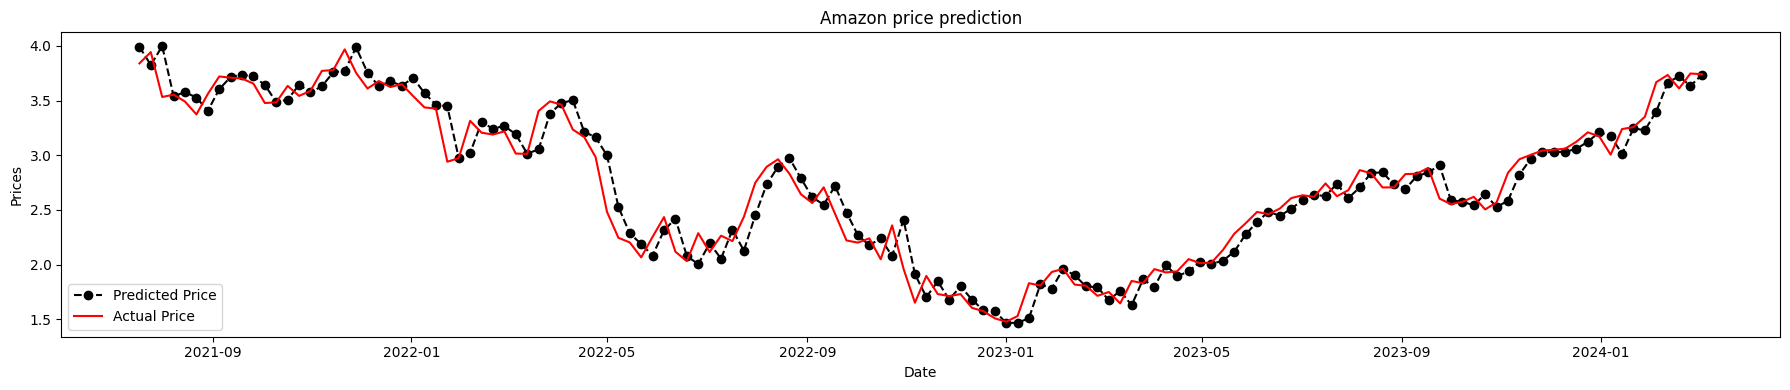

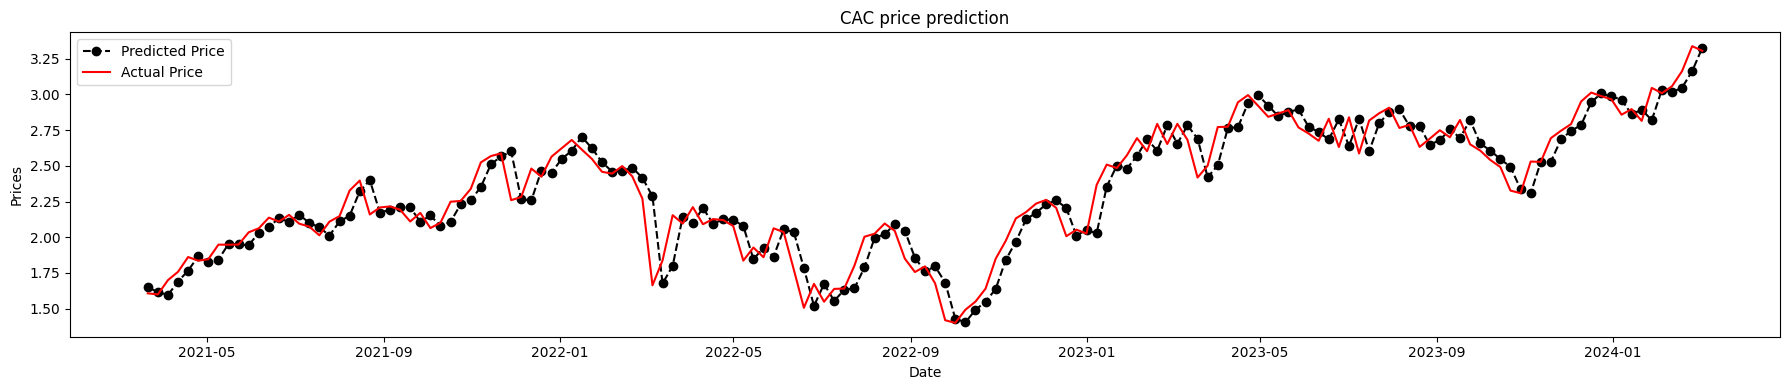

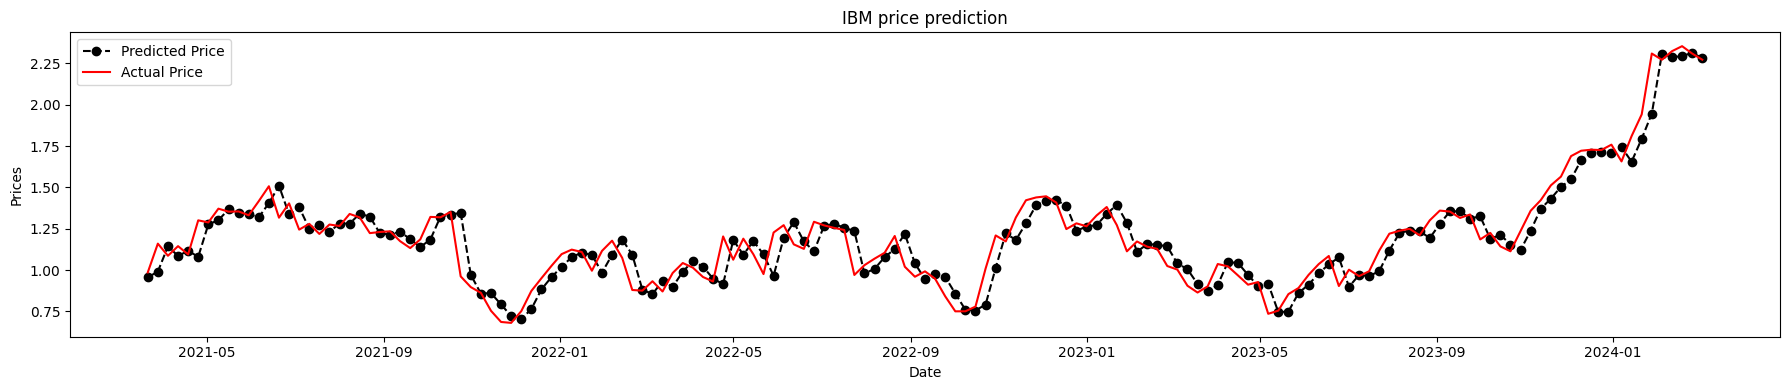

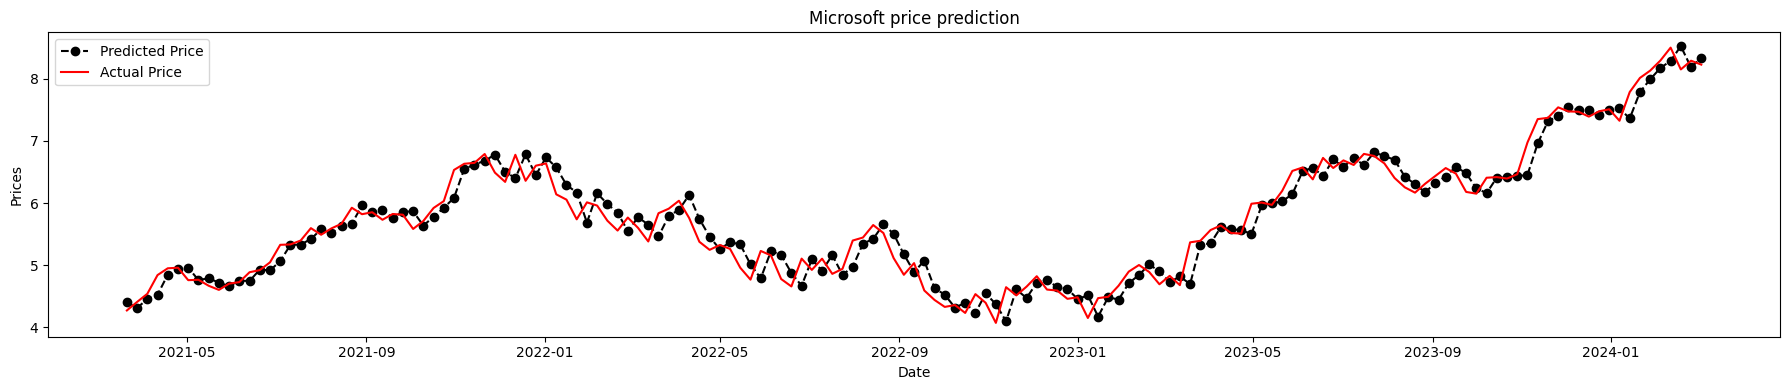

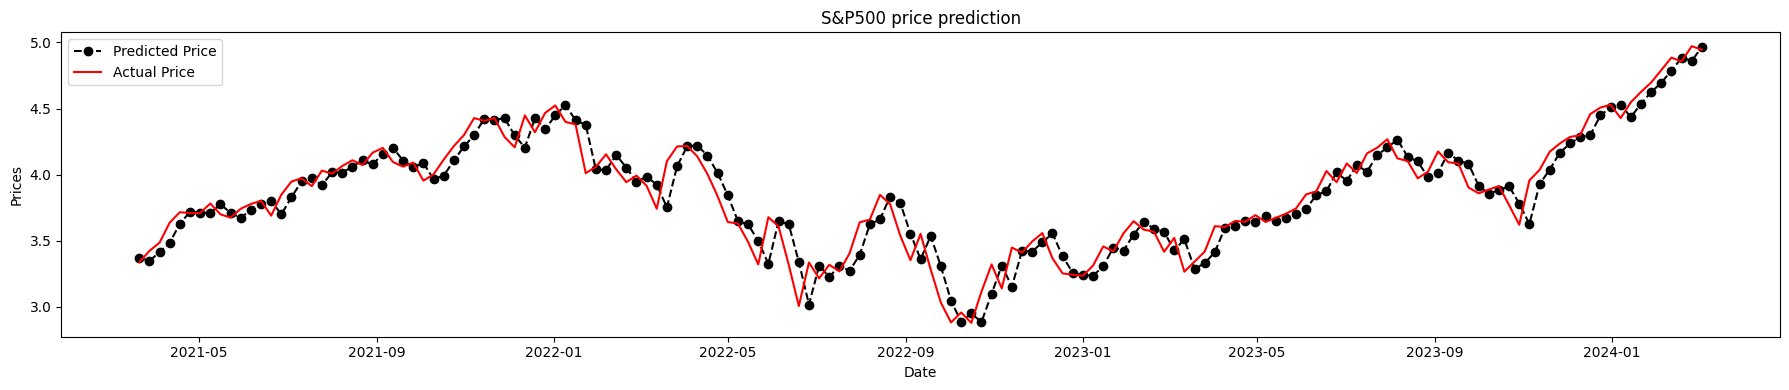

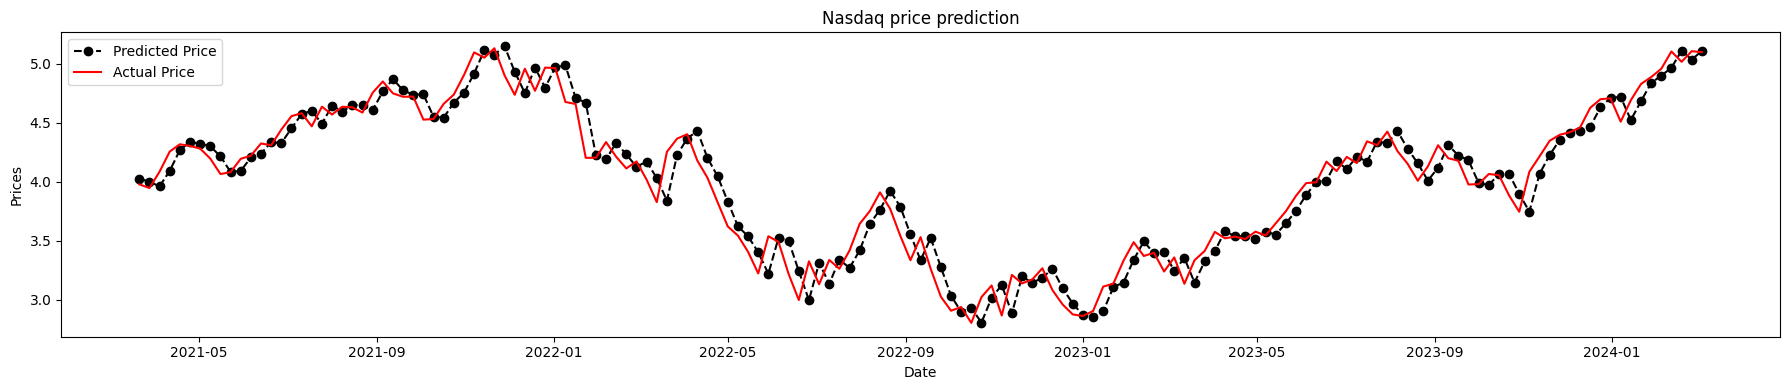

In [155]:
# Plotting ARIMA results graphically 
def plotting_prediction(reuslts, test_data, name):
    plt.figure(figsize=(18, 4))
    plt.plot(test_data['Date'], reuslts['arima_prediction'], color='black', marker='o', linestyle='dashed', label='Predicted Price')
    plt.plot(test_data['Date'], test_data['Close'], color='red', label='Actual Price')
    plt.title(f"{name} price prediction")
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.tight_layout()  
    plt.show()
    
plotting_prediction(amazon_results, test_amazon_std, "Amazon")
plotting_prediction(cac_results, test_cac_std, "CAC")
plotting_prediction(ibm_results, test_ibm_std, "IBM")
plotting_prediction(microsoft_results, test_microsoft_std, "Microsoft")
plotting_prediction(sp500_results, test_sp500_std, "S&P500")
plotting_prediction(nasdaq_results, test_nasdaq_std, "Nasdaq")

Next, the accuracy of the model is calculated by examining how many correct predictions the model makes (excluding cases where the model predicts 0)

In [156]:
# compute how many times arima gives the right signal
def trading_accuracy(df, signal_name):
    # Filter the DataFrame to exclude rows where the signal is 0
    filtered_df = df[(df[signal_name] != 0)]
    exact_prediction = 0
    wrong_prediction = 0
    for index, row in filtered_df.iterrows():
        if row[signal_name] == 1 and row['Market Direction'] == 'up' or row[signal_name] == -1 and row['Market Direction'] == 'down':
            exact_prediction += 1
        else:
            wrong_prediction += 1
    return exact_prediction / (exact_prediction + wrong_prediction)

print('Amazon ARIMA accuracy:', trading_accuracy(amazon_results, 'arima_signal'))
print('CAC ARIMA accuracy:', trading_accuracy(cac_results, 'arima_signal'))
print('IBM ARIMA accuracy:', trading_accuracy(ibm_results, 'arima_signal'))
print('Microsoft ARIMA accuracy:', trading_accuracy(microsoft_results, 'arima_signal'))
print('SP500 ARIMA accuracy:', trading_accuracy(sp500_results, 'arima_signal'))
print('Nasdaq ARIMA accuracy:', trading_accuracy(nasdaq_results, 'arima_signal'))

Amazon ARIMA accuracy: 0.5161290322580645
CAC ARIMA accuracy: 0.4959349593495935
IBM ARIMA accuracy: 0.5174825174825175
Microsoft ARIMA accuracy: 0.44776119402985076
SP500 ARIMA accuracy: 0.5238095238095238
Nasdaq ARIMA accuracy: 0.5193798449612403


In addition to the accuracy measure, we compute the confusion matrix. This measure, in addition to telling us how accurate the model is, gives us an idea of "how" the model gets the prediction wrong by providing the false negative e and false positive.

In [157]:
def confusion_matrix_results(df, signal_name):
    # Map 'Market Direction' to numerical values: 'up' to 1 and 'down' to -1
    df['True Labels'] = df['Market Direction'].map({'up': 1, 'down': -1})

    # Filter the DataFrame to exclude rows where 'lstm_signal' is 0
    filtered_df = df[df[signal_name] != 0]

    # Compute the confusion matrix for the filtered DataFrame
    cm = confusion_matrix(filtered_df['True Labels'], filtered_df[signal_name], labels=[-1, 1])
    return cm

cm_amz_arima = confusion_matrix_results(amazon_results, 'arima_signal')
cm_cac_arima = confusion_matrix_results(cac_results, 'arima_signal')
cm_ibm_arima = confusion_matrix_results(ibm_results, 'arima_signal')
cm_microsoft_arima = confusion_matrix_results(microsoft_results, 'arima_signal')
cm_sp500_arima = confusion_matrix_results(sp500_results, 'arima_signal')
cm_nasdaq_arima = confusion_matrix_results(nasdaq_results, 'arima_signal')

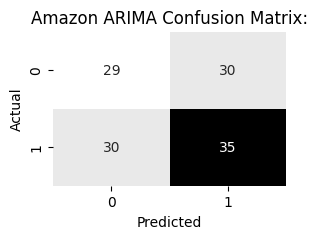

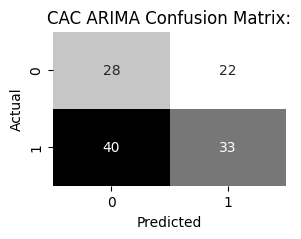

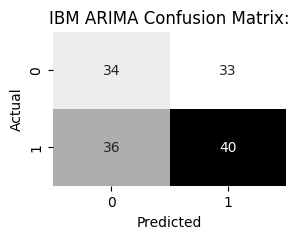

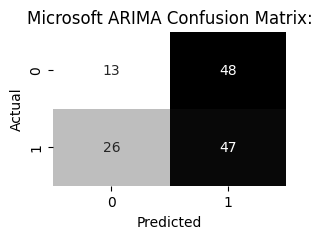

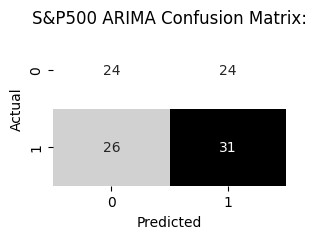

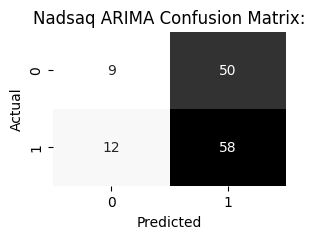

In [158]:
# Defining a function to print the CM as an Heatmap 
def print_cm(cm, name, model):
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greys", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} {model} Confusion Matrix:")
    plt.show()
        
print_cm(cm_amz_arima, 'Amazon', 'ARIMA')
print_cm(cm_cac_arima, 'CAC', 'ARIMA')
print_cm(cm_ibm_arima, 'IBM', 'ARIMA')
print_cm(cm_microsoft_arima, 'Microsoft', 'ARIMA')
print_cm(cm_sp500_arima, 'S&P500', 'ARIMA')
print_cm(cm_nasdaq_arima, 'Nadsaq', 'ARIMA')

Classification report for the ARIMA model

In [159]:
def class_report(results, name, signal):
    class_report = classification_report(results['Trading Signal'], results[signal])
    print(f"{name} classification report:")
    print("")
    print(f"{class_report}\n")

class_report(amazon_results, "Amazon", 'arima_signal')
class_report(cac_results, "CAC", 'arima_signal')
class_report(ibm_results, "IBM", 'arima_signal')
class_report(microsoft_results, "Microsoft", 'arima_signal')
class_report(sp500_results, "S&P500", 'arima_signal')
class_report(nasdaq_results, "Nasdaq", 'arima_signal')

Amazon classification report:

              precision    recall  f1-score   support

          -1       0.31      0.43      0.36        42
           0       0.43      0.11      0.18        54
           1       0.31      0.48      0.37        42

    accuracy                           0.32       138
   macro avg       0.35      0.34      0.30       138
weighted avg       0.35      0.32      0.29       138


CAC classification report:

              precision    recall  f1-score   support

          -1       0.26      0.43      0.33        42
           0       0.25      0.13      0.17        62
           1       0.35      0.37      0.36        51

    accuracy                           0.29       155
   macro avg       0.29      0.31      0.29       155
weighted avg       0.29      0.29      0.27       155


IBM classification report:

              precision    recall  f1-score   support

          -1       0.33      0.49      0.39        47
           0       0.42      0.10      0

## LSTM results

As before, we compute the accuracy for the LSTM model.

In [160]:
# compute how many times arima gives the right signal
def trading_accuracy(df, signal_name):
    # Filter the DataFrame to exclude rows where 'lstm_signal' is 0
    filtered_df = df[(df[signal_name] != 0)]
    exact_prediction = 0
    wrong_prediction = 0
    for index, row in filtered_df.iterrows():
        if row[signal_name] == 1 and row['Market Direction'] == 'up' or row[signal_name] == -1 and row['Market Direction'] == 'down':
            exact_prediction += 1
        else:
            wrong_prediction += 1
    return exact_prediction / (exact_prediction + wrong_prediction)

print('Amazon LSTM accuracy:', trading_accuracy(amazon_results, 'lstm_signal'))
print('CAC LSTM accuracy:', trading_accuracy(cac_results, 'lstm_signal'))
print('IBM LSTM accuracy:', trading_accuracy(ibm_results, 'lstm_signal'))
print('Microsoft LSTM accuracy:', trading_accuracy(microsoft_results, 'lstm_signal'))
print('SP500 LSTM accuracy:', trading_accuracy(sp500_results, 'lstm_signal'))
print('Nasdaq LSTM accuracy:', trading_accuracy(nasdaq_results, 'lstm_signal'))

Amazon LSTM accuracy: 0.5057471264367817
CAC LSTM accuracy: 0.5217391304347826
IBM LSTM accuracy: 0.7368421052631579
Microsoft LSTM accuracy: 0.44516129032258067
SP500 LSTM accuracy: 0.45161290322580644
Nasdaq LSTM accuracy: 0.5290322580645161


In addition to the accuracy, we can visualize the performance of our models through the ROC curve. The ROC (Receiver Operating Characteristic) curve and its AUC (Area Under the Curve) provide valuable insights into the performance of your classification model. AUC represents the likelihood that the model can distinguish between the classes.  

The AUC can take any value between 0 and 1. The higher the AUC, the better the model is at distinguishing between positive ('up') and negative ('down') classes.

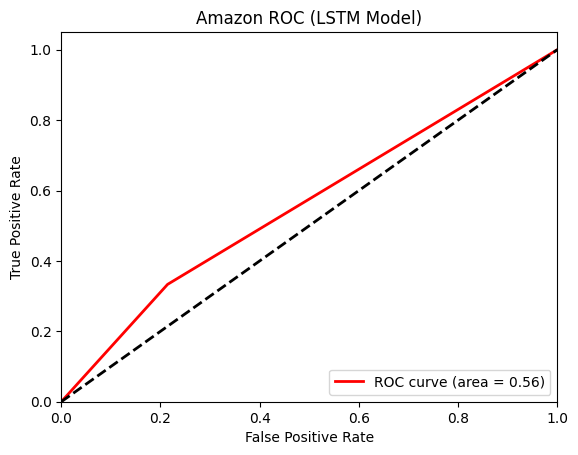

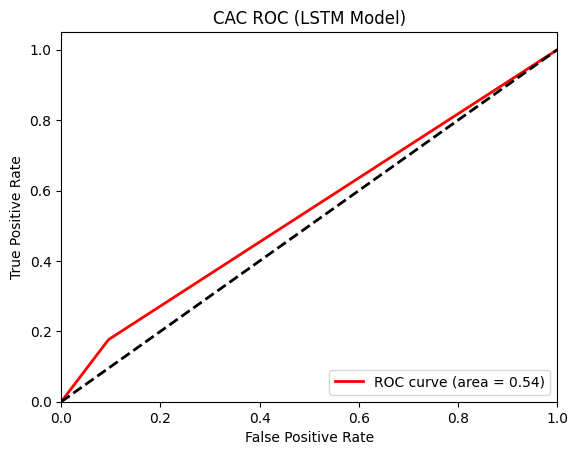

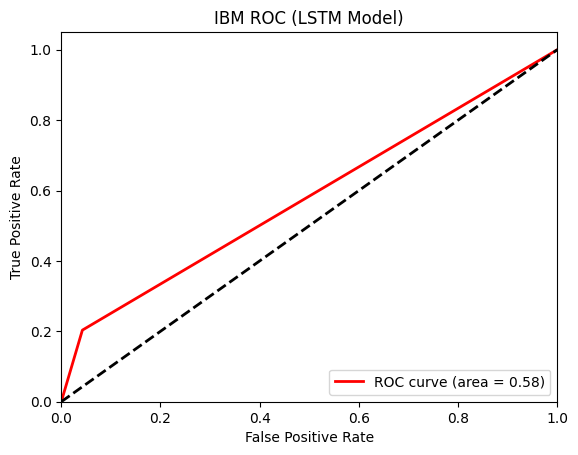

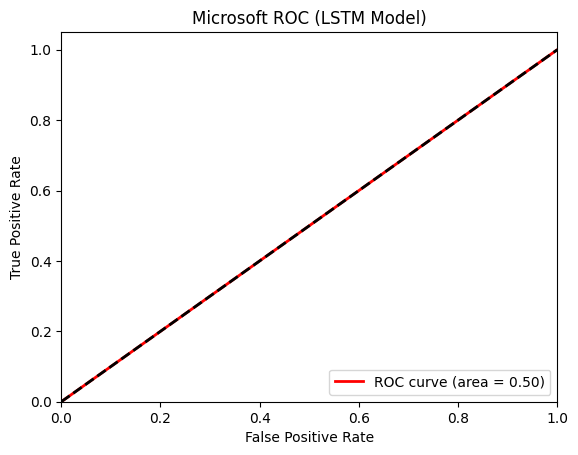

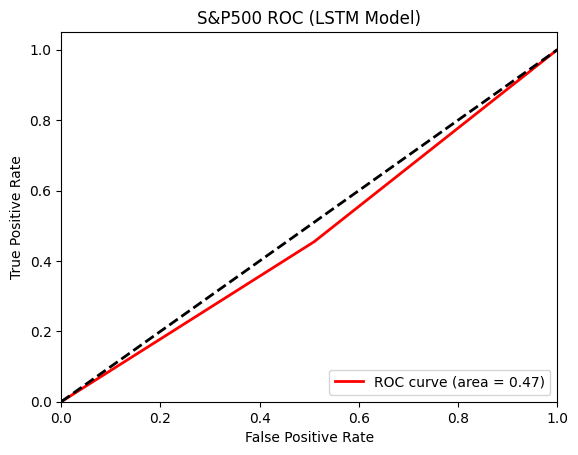

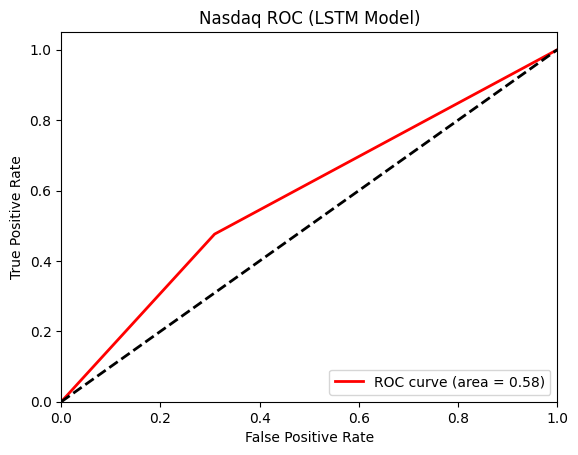

In [161]:
def ROC_plot(results, name, model, signal):
    filtered_result = results[(results['Trading Signal'] != 0)]
    predicted_probabilities = filtered_result[signal].apply(lambda x: 1 if x > 0 else 0)  # Normalizing for 0 or 1 output

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(filtered_result['Trading Signal'], predicted_probabilities)
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    # Plot
    plt.figure()
    plt.plot(fpr, tpr, color = 'red', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'black', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC ({model} Model)')
    plt.legend(loc="lower right")
    plt.show()

ROC_plot(amazon_results, "Amazon", "LSTM", "lstm_signal")
ROC_plot(cac_results, "CAC", "LSTM", "lstm_signal")
ROC_plot(ibm_results, "IBM", "LSTM", "lstm_signal")
ROC_plot(microsoft_results, "Microsoft", "LSTM", "lstm_signal")
ROC_plot(sp500_results, "S&P500", "LSTM", "lstm_signal")
ROC_plot(nasdaq_results, "Nasdaq", "LSTM", "lstm_signal")

Confusion matrices for the LSTM model

In [162]:
def confusion_matrix_results(df, signal_name):
    # Map 'Market Direction' to numerical values: 'up' to 1 and 'down' to -1
    df['True Labels'] = df['Market Direction'].map({'up': 1, 'down': -1})

    # Filter the DataFrame to exclude rows where 'lstm_signal' is 0
    filtered_df = df[df[signal_name] != 0]

    # Compute the confusion matrix for the filtered DataFrame
    cm = confusion_matrix(filtered_df['True Labels'], filtered_df[signal_name], labels=[-1, 1])
    return cm


cm_amz_lstm = confusion_matrix_results(amazon_results, 'lstm_signal')
cm_cac_lstm = confusion_matrix_results(cac_results, 'lstm_signal')
cm_ibm_lstm = confusion_matrix_results(ibm_results, 'lstm_signal')
cm_microsoft_lstm = confusion_matrix_results(microsoft_results, 'lstm_signal')
cm_sp500_lstm = confusion_matrix_results(sp500_results, 'lstm_signal')
cm_nasdaq_lstm = confusion_matrix_results(nasdaq_results, 'lstm_signal')

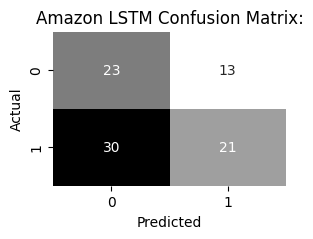

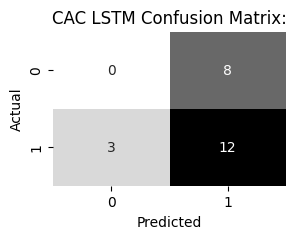

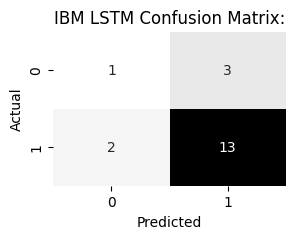

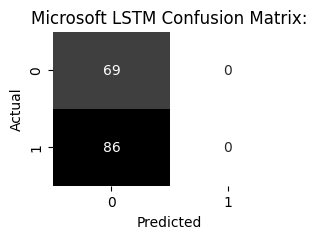

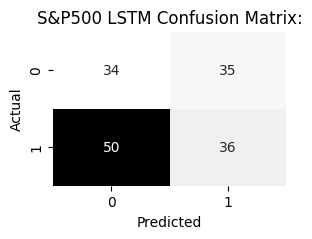

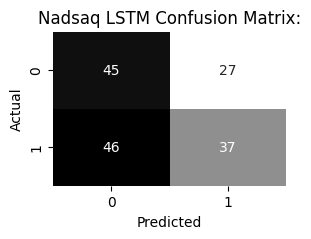

In [163]:
print_cm(cm_amz_lstm, 'Amazon', 'LSTM')
print_cm(cm_cac_lstm, 'CAC', 'LSTM')
print_cm(cm_ibm_lstm, 'IBM', 'LSTM')
print_cm(cm_microsoft_lstm, 'Microsoft', 'LSTM')
print_cm(cm_sp500_lstm, 'S&P500', 'LSTM')
print_cm(cm_nasdaq_lstm, 'Nadsaq', 'LSTM')

Classification report for the LSTM:

In [164]:
class_report(amazon_results, "Amazon", 'lstm_signal')
class_report(cac_results, "CAC", 'lstm_signal')
class_report(ibm_results, "IBM", 'lstm_signal')
class_report(microsoft_results, "Microsoft", 'lstm_signal')
class_report(sp500_results, "S&P500", 'lstm_signal')
class_report(nasdaq_results, "Nasdaq", 'lstm_signal')

Amazon classification report:

              precision    recall  f1-score   support

          -1       0.23      0.29      0.25        42
           0       0.35      0.33      0.34        54
           1       0.41      0.33      0.37        42

    accuracy                           0.32       138
   macro avg       0.33      0.32      0.32       138
weighted avg       0.33      0.32      0.32       138


CAC classification report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        42
           0       0.41      0.87      0.56        62
           1       0.45      0.18      0.25        51

    accuracy                           0.41       155
   macro avg       0.29      0.35      0.27       155
weighted avg       0.31      0.41      0.31       155


IBM classification report:

              precision    recall  f1-score   support

          -1       0.33      0.02      0.04        47
           0       0.34      0.94      0

## SVM results

Accuracy for the SVM results

In [165]:
print('Amazon SVM accuracy:', trading_accuracy(amazon_results, 'svm_signal'))
print('CAC SVM accuracy:', trading_accuracy(cac_results, 'svm_signal'))
print('IBM SVM accuracy:', trading_accuracy(ibm_results, 'svm_signal'))
print('Microsoft SVM accuracy:', trading_accuracy(microsoft_results, 'svm_signal'))
print('SP500 SVM accuracy:', trading_accuracy(sp500_results, 'svm_signal'))
print('Nasdaq SVM accuracy:', trading_accuracy(nasdaq_results, 'svm_signal'))

Amazon SVM accuracy: 0.5849056603773585
CAC SVM accuracy: 0.40540540540540543
IBM SVM accuracy: 0.5384615384615384
Microsoft SVM accuracy: 0.5694444444444444
SP500 SVM accuracy: 0.5548387096774193
Nasdaq SVM accuracy: 0.535483870967742


As before, let's visualize the ROC curves

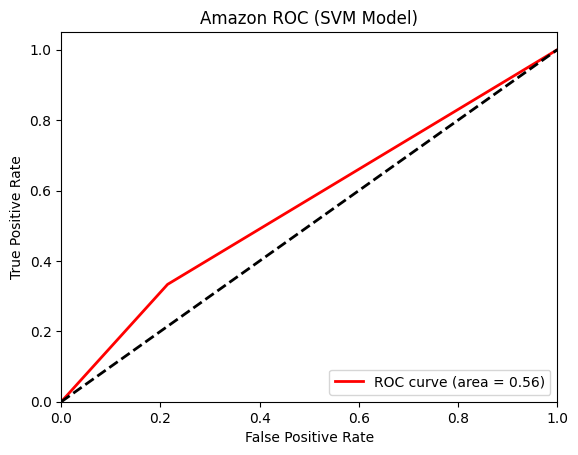

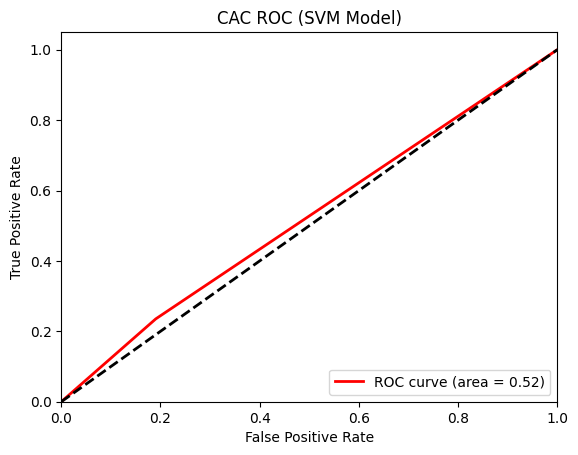

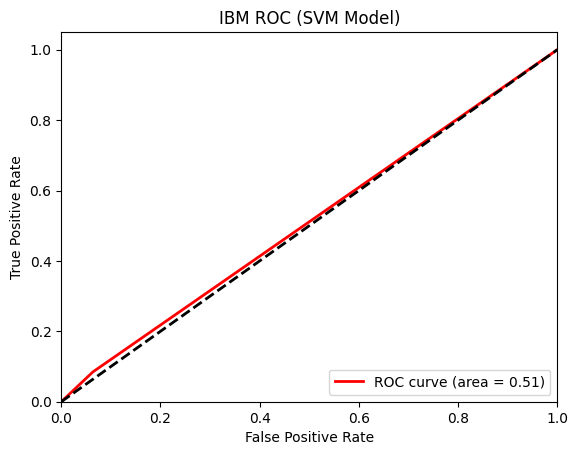

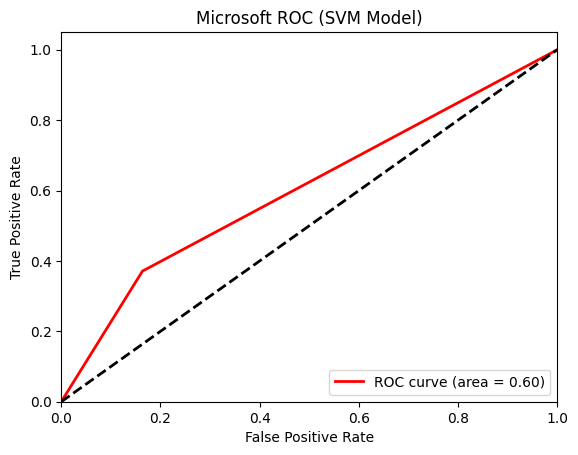

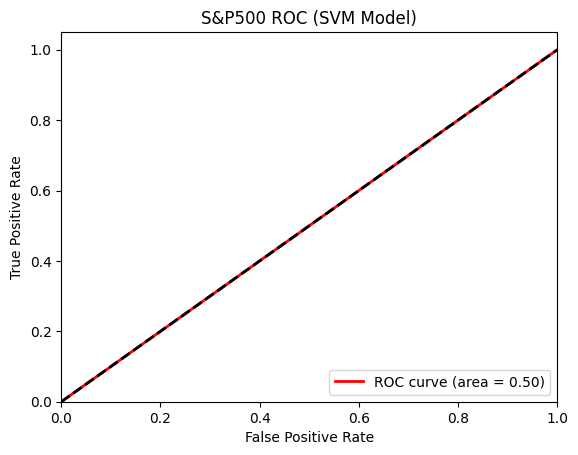

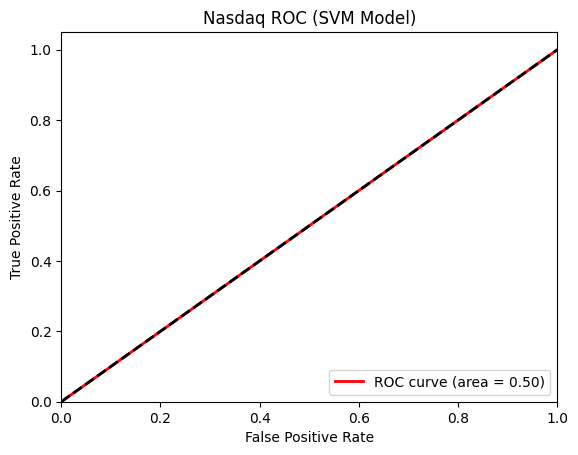

In [166]:
ROC_plot(amazon_results, "Amazon", "SVM", "svm_signal")
ROC_plot(cac_results, "CAC", "SVM", "svm_signal")
ROC_plot(ibm_results, "IBM", "SVM", "svm_signal")
ROC_plot(microsoft_results, "Microsoft", "SVM", "svm_signal")
ROC_plot(sp500_results, "S&P500", "SVM", "svm_signal")
ROC_plot(nasdaq_results, "Nasdaq", "SVM", "svm_signal")

Confusion matrices for the SVM model

In [167]:
cm_amz_svm = confusion_matrix_results(amazon_results, 'svm_signal')
cm_cac_svm = confusion_matrix_results(cac_results, 'svm_signal')
cm_ibm_svm = confusion_matrix_results(ibm_results, 'svm_signal')
cm_microsoft_svm = confusion_matrix_results(microsoft_results, 'svm_signal')
cm_sp500_svm = confusion_matrix_results(sp500_results, 'svm_signal')
cm_nasdaq_svm = confusion_matrix_results(nasdaq_results, 'svm_signal')

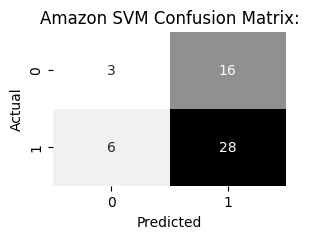

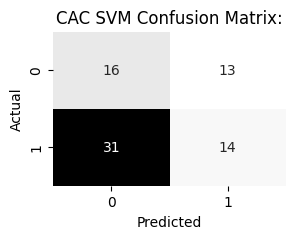

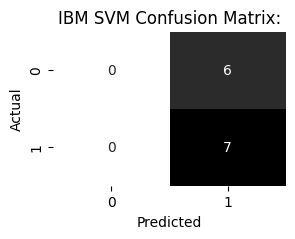

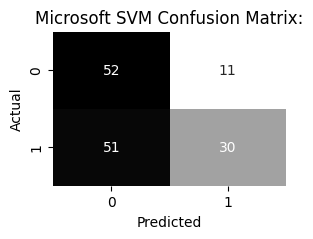

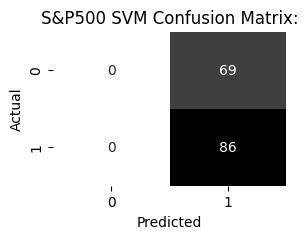

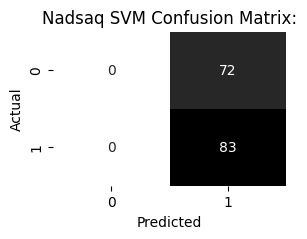

In [168]:
print_cm(cm_amz_svm, 'Amazon', 'SVM')
print_cm(cm_cac_svm, 'CAC', 'SVM')
print_cm(cm_ibm_svm, 'IBM', 'SVM')
print_cm(cm_microsoft_svm, 'Microsoft', 'SVM')
print_cm(cm_sp500_svm, 'S&P500', 'SVM')
print_cm(cm_nasdaq_svm, 'Nadsaq', 'SVM')

Finally, classification report for SVM model:

In [169]:
class_report(amazon_results, "Amazon", 'svm_signal')
class_report(cac_results, "CAC", 'svm_signal')
class_report(ibm_results, "IBM", 'svm_signal')
class_report(microsoft_results, "Microsoft", 'svm_signal')
class_report(sp500_results, "S&P500", 'svm_signal')
class_report(nasdaq_results, "Nasdaq", 'svm_signal')

Amazon classification report:

              precision    recall  f1-score   support

          -1       0.33      0.07      0.12        42
           0       0.38      0.59      0.46        54
           1       0.32      0.33      0.33        42

    accuracy                           0.36       138
   macro avg       0.34      0.33      0.30       138
weighted avg       0.35      0.36      0.32       138


CAC classification report:

              precision    recall  f1-score   support

          -1       0.21      0.24      0.22        42
           0       0.44      0.58      0.50        62
           1       0.44      0.24      0.31        51

    accuracy                           0.37       155
   macro avg       0.37      0.35      0.35       155
weighted avg       0.38      0.37      0.36       155


IBM classification report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        47
           0       0.31      0.90      0

## Random Forest results

In conclusion, let's assess the results of the Random Forest. Same iteration: accuracy, confusion matrices and ROC curves.

In [170]:
# Check accuracy
print('Amazon Random Forest accuracy:', trading_accuracy(amazon_results, 'random_forest_signal'))
print('CAC Random Forest accuracy:', trading_accuracy(cac_results, 'random_forest_signal'))
print('IBM Random Forest accuracy:', trading_accuracy(ibm_results, 'random_forest_signal'))
print('Microsoft Random Forest accuracy:', trading_accuracy(microsoft_results, 'random_forest_signal'))
print('SP500 Random Forest accuracy:', trading_accuracy(sp500_results, 'random_forest_signal'))
print('Nasdaq Random Forest accuracy:', trading_accuracy(nasdaq_results, 'random_forest_signal'))

Amazon Random Forest accuracy: 0.5161290322580645
CAC Random Forest accuracy: 0.48514851485148514
IBM Random Forest accuracy: 0.5174825174825175
Microsoft Random Forest accuracy: 0.47619047619047616
SP500 Random Forest accuracy: 0.5238095238095238
Nasdaq Random Forest accuracy: 0.5193798449612403


Confusion matrices for the Random Forest

In [171]:
cm_amz_rf = confusion_matrix_results(amazon_results, 'random_forest_signal')
cm_cac_rf = confusion_matrix_results(cac_results, 'random_forest_signal')
cm_ibm_rf = confusion_matrix_results(ibm_results, 'random_forest_signal')
cm_microsoft_rf = confusion_matrix_results(microsoft_results, 'random_forest_signal')
cm_sp500_rf = confusion_matrix_results(sp500_results, 'random_forest_signal')
cm_nasdaq_rf = confusion_matrix_results(nasdaq_results, 'random_forest_signal')

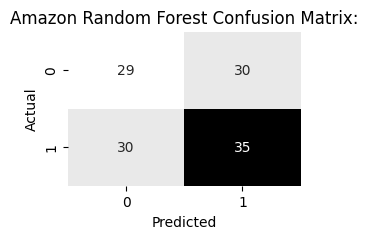

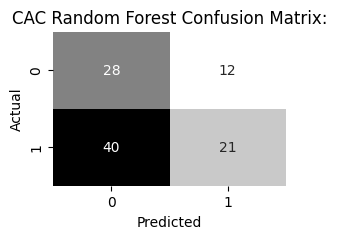

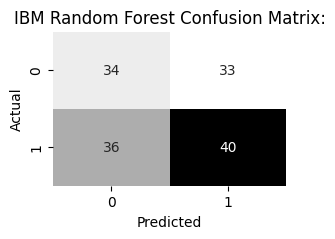

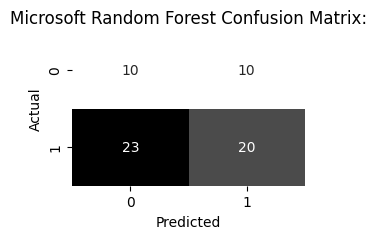

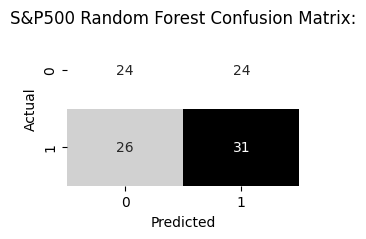

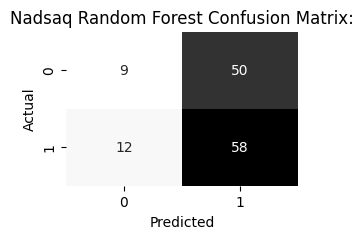

In [172]:
print_cm(cm_amz_rf, 'Amazon', 'Random Forest')
print_cm(cm_cac_rf, 'CAC', 'Random Forest')
print_cm(cm_ibm_rf, 'IBM', 'Random Forest')
print_cm(cm_microsoft_rf, 'Microsoft', 'Random Forest')
print_cm(cm_sp500_rf, 'S&P500', 'Random Forest')
print_cm(cm_nasdaq_rf, 'Nadsaq', 'Random Forest')

ROC curves for Random Forest

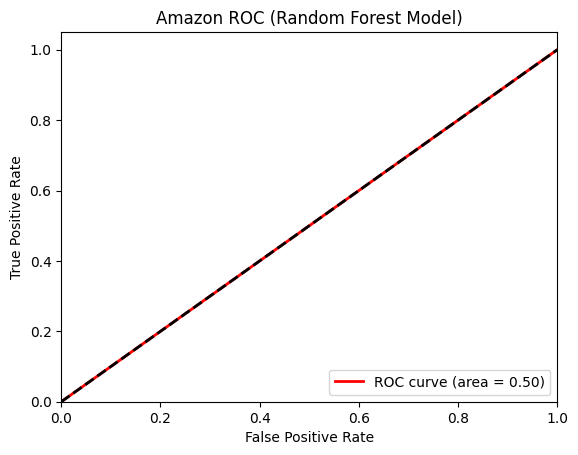

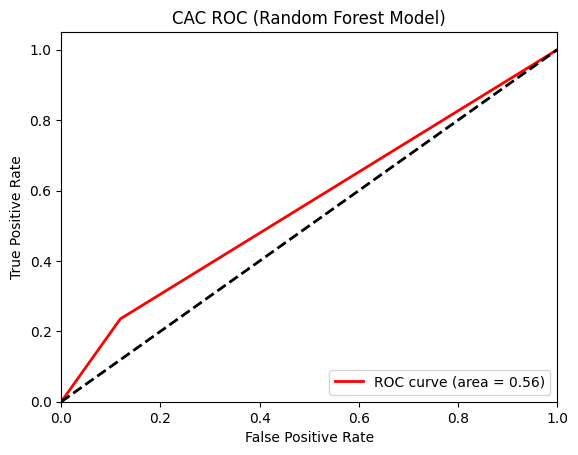

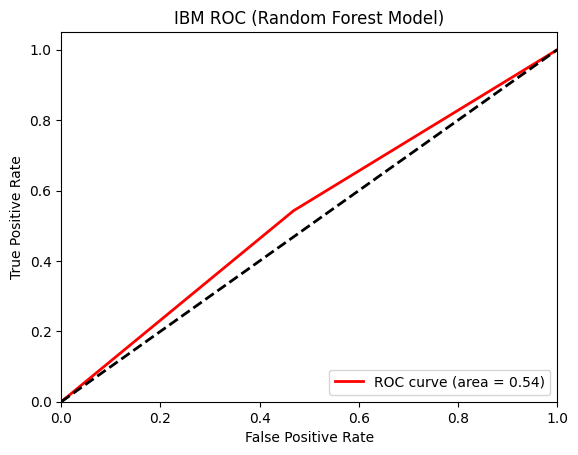

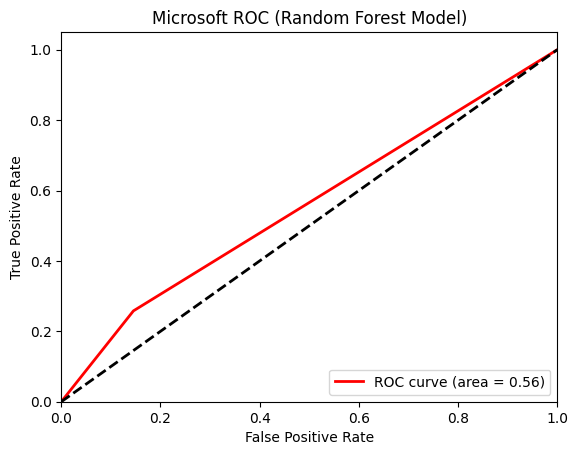

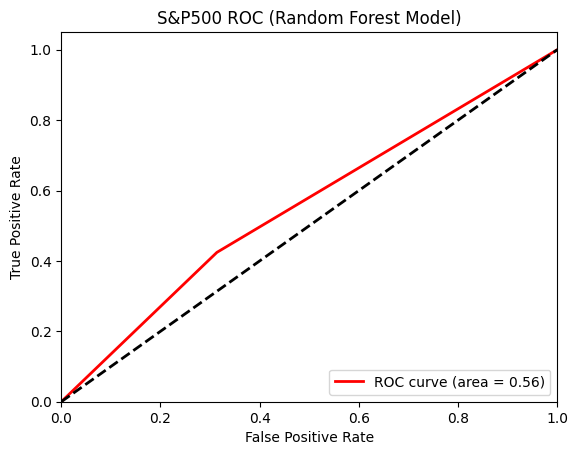

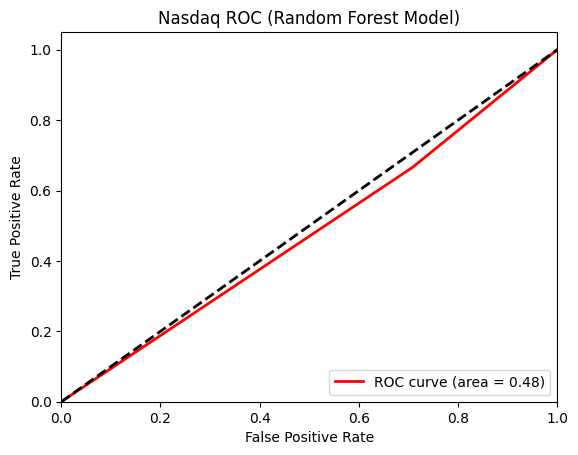

In [173]:
ROC_plot(amazon_results, "Amazon", 'Random Forest', 'random_forest_signal')
ROC_plot(cac_results, "CAC", 'Random Forest', 'random_forest_signal')
ROC_plot(ibm_results, "IBM", 'Random Forest', 'random_forest_signal')
ROC_plot(microsoft_results, "Microsoft", 'Random Forest', 'random_forest_signal')
ROC_plot(sp500_results, "S&P500", 'Random Forest', 'random_forest_signal')
ROC_plot(nasdaq_results, "Nasdaq", 'Random Forest', 'random_forest_signal')

# Performance of a simple model who predicts always 1

As baseline model, we used a simple model that predict always to go long without looking at the market behavior. Hence, we evaluate its results to compare them with those of our models.

Accuracy:

In [174]:
# compute how many times arima gives the right signal
def trading_accuracy_always_1(df):
    exact_prediction = 0
    for index, row in df.iterrows():
        if row['Market Direction'] == 'up':
            exact_prediction += 1
    return exact_prediction / (len(df))

print('Amazon accuracy:', trading_accuracy_always_1(amazon_results))
print('CAC accuracy:', trading_accuracy_always_1(cac_results))
print('IBM accuracy:', trading_accuracy_always_1(ibm_results))
print('Microsoft accuracy:', trading_accuracy_always_1(microsoft_results))
print('SP500 accuracy:', trading_accuracy_always_1(sp500_results))
print('Nasdaq accuracy:', trading_accuracy_always_1(nasdaq_results))

Amazon accuracy: 0.5144927536231884
CAC accuracy: 0.5612903225806452
IBM accuracy: 0.535483870967742
Microsoft accuracy: 0.5548387096774193
SP500 accuracy: 0.5548387096774193
Nasdaq accuracy: 0.535483870967742
